# Direct DM detection using NR EFT (Fitzpatrick et al. 1203.3542)

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import division    #for division operator
import swordfish as sf
import math, numpy as np
from astropy import constants as const
from astropy import units as u
from astropy import coordinates as coord
from scipy.special import erf, spherical_jn
from scipy.integrate import quad, odeint, simps, nquad
import scipy.stats as stats
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline, griddata
import matplotlib.pylab as plt

from time import sleep
from tqdm import tqdm

infilepath = '/Users/jatan/Desktop/light_mediator_dd/'
outfilepath = '/Users/jatan/Desktop/light_mediator_dd/plots/'

plt.style.use('seaborn-bright')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100

## Velocity conversion for Earth's reference frame between coordinates systems

The premise for this digression is that the Earth's velocity model in references like astro-ph/0304446 and astro-ph/0607121 are written in galactic coordinates ($l$, $b$, $r$). The dark matter halo/substructure literature uses galactocentric coordinates ($\theta$, $\phi$, $R$). It is therefore a need to convert the Earth's velocity description to those of Milky Way dark matter. 

Calculating and defining the average 3 dimensional DM velocity relative to the Earth in the Galactocentric frame

>**f_v_earth(_day_, _coord_)**  return scalar

>Output the _Coord_ componemnt ($x,y,z$ or $r,\theta,\phi$ in galactocentric frame) velocity in km/s on the _day_ of the year

> **f_v_earth_monthly_**

>A 12-component vectors that store the average DM velocity twelve months a year.

In [8]:
#astro-ph/0304446, astro-ph/0607121
#in (cartesian) galactic coordinates
ep_rot_1 = np.array([0.9931,0.1170,-0.01032]) # 1st quadrant
ep_rot_2 = np.array([-0.0670,0.4927,-0.8676]) # 2nd quadrant

ep_rot_1_b = np.arcsin(ep_rot_1[2])
ep_rot_1_l = np.arccos(ep_rot_1[0]/np.cos(ep_rot_1_b))
ep_rot_2_b = np.arcsin(ep_rot_2[2])
ep_rot_2_l = np.arccos(ep_rot_2[0]/np.cos(ep_rot_2_b))

ep_rot_1_gal = coord.Galactic(l=ep_rot_1_l*u.rad, b=ep_rot_1_b*u.rad,distance=1000.*u.kpc)
ep_rot_2_gal = coord.Galactic(l=ep_rot_2_l*u.rad, b=ep_rot_2_b*u.rad,distance=1000.*u.kpc)

ep_rot_1_galcen = ep_rot_1_gal.transform_to(coord.Galactocentric)
ep_rot_2_galcen = ep_rot_2_gal.transform_to(coord.Galactocentric)


ep_rot_1_galcen_vec = np.array([ep_rot_1_galcen.transform_to(coord.Galactocentric).x/(1000.*u.kpc), \
                               ep_rot_1_galcen.transform_to(coord.Galactocentric).y/(1000.*u.kpc), \
                               ep_rot_1_galcen.transform_to(coord.Galactocentric).z/(1000.*u.kpc)])
ep_rot_2_galcen_vec = np.array([ep_rot_2_galcen.transform_to(coord.Galactocentric).x/(1000.*u.kpc), \
                               ep_rot_2_galcen.transform_to(coord.Galactocentric).y/(1000.*u.kpc), \
                               ep_rot_2_galcen.transform_to(coord.Galactocentric).z/(1000.*u.kpc)])

def f_v_earth(day, coord = None):
    v_LSR = np.array([0. , 235., 0.]) # local standard of rest
    v_sun = np.array([8.5, 13.38, 6.49]) # sun's peculiar velocity
    year = 365. # length of a year in days
    v_earth_o = 29.79 # earth orbital speed
    t0 = 79.55 # vernal equinox
    
    vec_indx = np.nan
    if coord == 'x' or coord == 'r':
        vec_indx = 0
    elif coord == 'y' or coord == 'the':
        vec_indx = 1
    elif coord == 'z' or coord == 'phi':
        vec_indx = 2
    
    v_e = v_LSR[vec_indx] + v_sun[vec_indx] + v_earth_o*(ep_rot_1_galcen_vec[vec_indx]*np.cos( (2*np.pi/year)*day-t0)\
                             + ep_rot_2_galcen_vec[vec_indx]*np.sin( (2*np.pi/year)*day-t0) )
    return v_e

month_transit = np.linspace(0.,365.,13)
days_of_year = np.linspace(0.,365.,366)

f_v_earth_monthly_r = np.empty(12)
for i in range (0,12):
    indx_month = (days_of_year > month_transit[i])*(days_of_year < month_transit[i+1])
    f_v_earth_monthly_r[i] = np.sum(f_v_earth(days_of_year[indx_month],'x'))/(1.*np.sum(indx_month))
f_v_earth_monthly_the = np.empty(12)
for i in range (0,12):
    indx_month = (days_of_year > month_transit[i])*(days_of_year < month_transit[i+1])
    f_v_earth_monthly_the[i] = np.sum(f_v_earth(days_of_year[indx_month],'y'))/(1.*np.sum(indx_month))
f_v_earth_monthly_phi = np.empty(12)
for i in range (0,12):
    indx_month = (days_of_year > month_transit[i])*(days_of_year < month_transit[i+1])
    f_v_earth_monthly_phi[i] = np.sum(f_v_earth(days_of_year[indx_month],'z'))/(1.*np.sum(indx_month))

### Some useful constants

In [9]:
fmtoInverseGeV= 1.0/0.197
AMUtoGeV= 0.93146
mProton= 0.938   #in GeV
mNeutron= 0.9396 #in GeV
GF= 1.166E-5     #in GeV^(-2)
keVtoGeV= 1e-6 
invVelToUnitless = 3.0E5

## Particle physics

### Nuclear properties

In [11]:
def mass_func(mDM, target):
    #returns mass of target, and reduced mass of target-DM system; in GeV
    
    if (target=='72Ge'):
        mT= 72.64*AMUtoGeV      #mass of Ge-nucleus
    elif (target=='131Xe'):
        mT= 131.3*AMUtoGeV
    
    return mT, mDM*mT/(mDM + mT)

def q_func(ER, mT):
    #ER in keV, mT in GeV
    return np.sqrt(2*mT*ER)

### Nuclear form factors/responses/matrix elements

Simplification functions for nucleus form factors

In [12]:
def b_func(A_param):
    return np.sqrt(41.167/(45*pow(A_param, -1/3) - 25*pow(A_param, -2/3)))*fmtoInverseGeV 

def y_func(q, b_param):
    return pow((q*b_param)/2, 2)  

def c_chi_func(j_chi):
    return 4*j_chi*(j_chi + 1)/3

Define the nuclear response functions from 1203.3542v3,

$F^{n,n'}_X \in \langle \mathcal{O}_a^n\times \mathcal{O}_b^{n'} \rangle$,

where $n, n' = $ neutron or proton labels the nucleons in nucleon-nucleon interference. $X$ labels the type of response. Each element has its own response function.

In [284]:
def F_M(y, n, nprime, nuclide):
    
    if y==0:
        return 1.0
    
    if (nuclide=='19F'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(81 - 96*y + 36*pow(y, 2) - 4.7*pow(y, 3) + 0.19*pow(y, 4))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(100 - 130*y + 61*pow(y, 2)  - 11*pow(y, 3) + 0.73*pow(y, 4))
        else:
            return np.exp(-2*y)*(90 - 110*y + 48*pow(y, 2)  - 7.5*pow(y, 3) + 0.37*pow(y, 4))
        
    if (nuclide=='72Ge'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(1000 - 2800*y + 3000*pow(y, 2) - 1500*pow(y, 3) + 400*pow(y, 4) - \
                           51*pow(y, 5) + 2.6*pow(y, 6) - 0.0069*pow(y, 7))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(1600 - 4800*y + 5600*pow(y, 2)  - 3100*pow(y, 3) + 910*pow(y, 4) - \
                           130*pow(y, 5) + 7.8*pow(y, 6) - 0.039*pow(y, 7))
        else:
            return np.exp(-2*y)*(1300 - 3700*y + 4100*pow(y, 2)  - 2200*pow(y, 3) + 600*pow(y, 4) - \
                           82*pow(y, 5) + 4.5*pow(y, 6) - 0.017*pow(y, 7))
        
    if (nuclide=='131Xe'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(2900 - 11000*y + 15000*pow(y, 2) - 10000*pow(y, 3) + 3800*pow(y, 4) - \
                           810*pow(y, 5) + 92*pow(y, 6) - 5.1*pow(y, 7) + 0.11*pow(y, 8))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(5900 - 25000*y + 43000*pow(y, 2)  - 37000*pow(y, 3) + 19000*pow(y, 4) - \
                           5500*pow(y, 5) + 980*pow(y, 6) - 97*pow(y, 7) + 4.9*pow(y, 8) - 0.0096*pow(y, 9) + \
                           0.0061*pow(y, 10)) 
        else:
            return np.exp(-2*y)*(4200 - 16000*y + 25000*pow(y, 2)  - 20000*pow(y, 3) + 8600*pow(y, 4) - \
                           2200*pow(y, 5) + 310*pow(y, 6) - 24*pow(y, 7) + 0.83*pow(y, 8) - 0.0082*pow(y, 9))

        
        
def F_D(y, n, nprime, nuclide):
    
    if y==0:
        return 1.0
    
    if (nuclide=='19F'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(0.0251 - 0.0201*y + 0.00401*pow(y, 2))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(0.0181 - 0.0145*y + 0.00290*pow(y, 2))
        else:
            return np.exp(-2*y)*(-0.0213 + 0.0170*y - 0.00341*pow(y, 2))
        
    if (nuclide=='72Ge'):
        return 0.
        
    if (nuclide=='131Xe'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(0.022 - 0.054*y + 0.053*pow(y, 2) - 0.026*pow(y, 3) + 0.0071*pow(y, 4) - 0.00098*pow(y, 5))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(0.56 - 1.4*y + 1.8*pow(y, 2)  - 1.3*pow(y, 3) + 0.51*pow(y, 4) - \
                           0.11*pow(y, 5) + 0.0097*pow(y, 6) - 0.00015*pow(y, 7)) 
        else:
            return np.exp(-2*y)*(0.11 - 0.28*y + 0.31*pow(y, 2)  - 0.19*pow(y, 3) + 0.062*pow(y, 4) - \
                           0.010*pow(y, 5) + 0.00073*pow(y, 6))

def F_Sp(y, n, nprime, nuclide):
    
    if y==0:
        return 1.0
    
    if (nuclide=='19F'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(1.81 - 4.85*y + 4.88*pow(y, 2) - 2.18*pow(y, 3) + 0.364*pow(y, 4))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(0.000607 - 0.00136*y + 0.000266*pow(y, 2)  + 0.000550*pow(y, 3) + 0.0000997*pow(y, 4)) 
        else:
            return np.exp(-2*y)*(-0.0331 + 0.0815*y - 0.0511*pow(y, 2)  - 0.00142*pow(y, 3) + 0.00602*pow(y, 4))
    if (nuclide=='72Ge'):
        return 0.        
    if (nuclide=='131Xe'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(0.00012 - 0.00089*y + 0.0015*pow(y, 2) + 0.0015*pow(y, 3) - 0.00069*pow(y, 4) - \
                           0.0012*pow(y, 5) + 0.00080*pow(y, 6) - 0.00016*pow(y, 7))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(0.18 - 1.6*y + 5.8*pow(y, 2)  - 9.7*pow(y, 3) + 9.1*pow(y, 4) - \
                           4.9*pow(y, 5) + 1.4*pow(y, 6) - 0.21*pow(y, 7) + 0.012*pow(y, 8)) 
        else:
            return np.exp(-2*y)*(0.0045 - 0.039*y + 0.095*pow(y, 2)  - 0.038*pow(y, 3) - 0.077*pow(y, 4) + \
                           0.087*pow(y, 5) - 0.035*pow(y, 6) + 0.0059*pow(y, 7))

        
def F_Spp(y, n, nprime, nuclide):
    
    if y==0:
        return 1.0
    
    if (nuclide=='19F'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(0.903 - 2.37*y + 2.35*pow(y, 2) - 1.05*pow(y, 3) + 0.175*pow(y, 4))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(0.000303 - 0.00107*y + 0.00114*pow(y, 2)  - 0.000348*pow(y, 3) + 0.0000320*pow(y, 4)) 
        else:
            return np.exp(-2*y)*(-0.0166 + 0.0509*y - 0.0510*pow(y, 2)  + 0.0199*pow(y, 3) - 0.00237*pow(y, 4))
    if (nuclide=='72Ge'):
        return 0.        
    if (nuclide=='131Xe'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(0.00013*pow(y, 2) - 0.00062*pow(y, 3) + 0.00088*pow(y, 4) - 0.00053*pow(y, 5) + 0.00015*pow(y, 6))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(0.088 + 0.30*y - 0.23*pow(y, 2)  - 0.47*pow(y, 3) + 1.2*pow(y, 4) - \
                           1.1*pow(y, 5) + 0.44*pow(y, 6) - 0.086*pow(y, 7) + 0.0067*pow(y, 8)) 
        else:
            return np.exp(-2*y)*(0.0023 + 0.0032*y - 0.011*pow(y, 2)  - 0.00077*pow(y, 3) + 0.019*pow(y, 4) - \
                           0.018*pow(y, 5) + 0.0066*pow(y, 6) - 0.0011*pow(y, 7))
        

        
def F_Sp_D(y, n, nprime, nuclide):
    
    if y==0:
        return 1.0
    
    if (nuclide=='19F'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(-0.213 + 0.315*y - 0.210*pow(y, 2) + 0.0382*pow(y, 3))
        elif (n == 'p') and (nprime == 'n') :
            return np.exp(-2*y)*(0.181 - 0.315*y + 0.178*pow(y, 2)  - 0.0325*pow(y, 3))
        elif (n == 'n') and (nprime == 'p') :
            return np.exp(-2*y)*(0.00390 - 0.00592*y + 0.000163*pow(y, 2)  + 0.000632*pow(y, 3))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(-0.00331 + 0.00503*y - 0.000138*pow(y, 2)  - 0.000537*pow(y, 3))        

    if (nuclide=='72Ge'):
        return 0.
        
    if (nuclide=='131Xe'):
        if (n == 'p') and (nprime == 'p') :
            return np.exp(-2*y)*(0.0016 - 0.0081*y + 0.0047*pow(y, 2) + 0.0049*pow(y, 3) - 0.0061*pow(y, 4) + \
                           0.0023*pow(y, 5) - 0.00039*pow(y, 6))
        elif (n == 'p') and (nprime == 'n') :
            return np.exp(-2*y)*(0.0080 - 0.041*y + 0.027*pow(y, 2)  + 0.020*pow(y, 3) - 0.038*pow(y, 4) + \
                           0.020*pow(y, 5) - 0.0042*pow(y, 6) + 0.00032*pow(y, 7))
        elif (n == 'n') and (nprime == 'p') :
            return np.exp(-2*y)*(0.063 - 0.37*y + 0.72*pow(y, 2)  - 0.68*pow(y, 3) + 0.35*pow(y, 4) - \
                           0.098*pow(y, 5) + 0.014*pow(y, 6) - 0.00077*pow(y, 7))
        elif (n == 'n') and (nprime == 'n') :
            return np.exp(-2*y)*(0.31 - 1.9*y + 3.8*pow(y, 2)  - 4.1*pow(y, 3) + 2.5*pow(y, 4) - \
                           0.87*pow(y, 5) + 0.15*pow(y, 6) - 0.011*pow(y, 7))  

The nuclear form factor is defined as the operator product,
$\langle\mathcal{O}_a^n \times \mathcal{O}_b^{n'}\rangle = F_{a,b}^{n,n'}$,

which is nonzero if $\mathcal{O}_a$ and $\mathcal{O}_b$ have the same quantum number. The exact form is written by matching the appropriate nuclear responses defined above. For the nucleus of an element $N$, if the interaction is an isoscalar,

$F_{a,b}^{N} = \langle(\mathcal{O}_a^n + \mathcal{O}_a^p) \times (\mathcal{O}_b^{n} + \mathcal{O}_b^{p})\rangle\\
\quad = \left\{\begin{matrix} F_{a,b}^{n,n} + F_{a,b}^{p,n} + F_{a,b}^{n,p} +F_{a,b}^{p,p} \quad {\rm if }\, a \neq b,  \\   F_{a,b}^{n,n} + 2F_{a,b}^{p,n} + F_{a,b}^{p,p} \quad {\rm \ if }\, a = b, \end{matrix}\right.$

since $F_{a,b}^{p,n} = F_{a,b}^{n,p}$ when $a=b$.

Otherwise if the interaction is isovector,

$F_{a,b}^{N} = F_{a,b}^{n,n} \;{\rm or}\; F_{a,b}^{p,p}$.

In [286]:
ER_array= np.linspace(1, 100, 10000)

def F_1_1(q, n, nprime, nuclide): #F_m    
    if q==0:
        return 1.0
    
    A=0.
    
    if (nuclide=='19F'):
        A= 19.00
    elif (nuclide=='72Ge'):
        A= 72.64  
    elif (nuclide=='131Xe'):
        A= 131.
    else:
        print "Data for %s not available!"%nuclide
        
    b= b_func(A)
    y= y_func(q, b)
    return F_M(y, n, nprime, nuclide)

f11_F_array = [np.sum([F_1_1(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'p', 'p', '19F'), 2*F_1_1(q_func(x*1e-6, 19.0*AMUtoGeV), 'p', 'n', '19F'), \
                                                                    F_1_1(q_func(x*1e-6, 19.0*AMUtoGeV), 'n', 'n', '19F')]) for x in ER_array]
f11_F_funct = interp1d(ER_array, f11_F_array, bounds_error = False, fill_value = "extrapolate")

f11_Xe_array = [np.sum([F_1_1(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'p', 'p', '131Xe'), 2*F_1_1(q_func(x*1e-6, 131.3*AMUtoGeV), 'p', 'n', '131Xe'), \
                                                                    F_1_1(q_func(x*1e-6, 131.3*AMUtoGeV), 'n', 'n', '131Xe')]) for x in ER_array]
f11_Xe_funct = interp1d(ER_array, f11_Xe_array, bounds_error = False, fill_value = "extrapolate")

f11_Ge_array = [np.sum([F_1_1(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'p', '72Ge'), 2*F_1_1(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'n', '72Ge'), \
                                                                F_1_1(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'n', '72Ge')]) for x in ER_array]
f11_Ge_funct = interp1d(ER_array, f11_Ge_array, bounds_error = False, fill_value = "extrapolate")


def F_4_4(q, n, nprime, nuclide, j_chi=1./2.): # (C(j)/16)*(F_S" + F_S')
    
    if q==0:
        return 1.0
    
    c_chi = c_chi_func(j_chi)
    
    A=0.    
    if (nuclide=='19F'):
        A= 19.00
    elif (nuclide=='72Ge'):
        A= 72.64  
    elif (nuclide=='131Xe'):
        A= 131.
    else:
        print "Data for %s not available!"%nuclide
        
    b= b_func(A)
    y= y_func(q, b)
    
    return (c_chi/16.)*(F_Spp(y, n, nprime, nuclide) + F_Sp(y, n, nprime, nuclide))

f44_F_array = [np.sum([F_4_4(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'p', 'p', '19F'), 2*F_4_4(q_func(x*1e-6, 19.0*AMUtoGeV), 'p', 'n', '19F'), \
                                                                    F_4_4(q_func(x*1e-6, 19.0*AMUtoGeV), 'n', 'n', '19F')]) for x in ER_array]
f44_F_funct = interp1d(ER_array, f44_F_array, bounds_error = False, fill_value = "extrapolate")

f44_Xe_array = [np.sum([F_4_4(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'p', 'p', '131Xe'), 2*F_4_4(q_func(x*1e-6, 131.3*AMUtoGeV), 'p', 'n', '131Xe'), \
                                                                    F_4_4(q_func(x*1e-6, 131.3*AMUtoGeV), 'n', 'n', '131Xe')]) for x in ER_array]
f44_Xe_funct = interp1d(ER_array, f44_Xe_array, bounds_error = False, fill_value = "extrapolate")

f44_Ge_array = [np.sum([F_4_4(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'p', '72Ge'), 2*F_4_4(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'n', '72Ge'), \
                                                                F_4_4(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'n', '72Ge')]) for x in ER_array]
f44_Ge_funct = interp1d(ER_array, f44_Ge_array, bounds_error = False, fill_value = "extrapolate")


def F_5_5_M_q(q, n, nprime, nuclide, j_chi=1./2.):
    
    if q==0:
        return 1.0
    
    c_chi = c_chi_func(j_chi)
    
    A=0.    
    if (nuclide=='19F'):
        A= 19.00
    elif (nuclide=='72Ge'):
        A= 72.64  
    elif (nuclide=='131Xe'):
        A= 131.
    else:
        print "Data for %s not available!"%nuclide
        
    b= b_func(A)
    y= y_func(q, b)
    
    return (c_chi/4.)*( (q**4/(4.))*F_M(y, n, nprime, nuclide) )


f55_M_q_F_array = [np.sum([F_5_5_M_q(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'p', 'p', '19F'), 2*F_5_5_M_q(q_func(x*1e-6, 19.0*AMUtoGeV), 'p', 'n', '19F'), \
                                                                    F_5_5_M_q(q_func(x*1e-6, 19.0*AMUtoGeV), 'n', 'n', '19F')]) for x in ER_array]
f55_M_q_F_funct = interp1d(ER_array, f55_M_q_F_array, bounds_error = False, fill_value = "extrapolate")

f55_M_q_Xe_array = [np.sum([F_5_5_M_q(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'p', 'p', '131Xe'), 2*F_5_5_M_q(q_func(x*1e-6, 131.3*AMUtoGeV), 'p', 'n', '131Xe'), \
                                                                    F_5_5_M_q(q_func(x*1e-6, 131.3*AMUtoGeV), 'n', 'n', '131Xe')]) for x in ER_array]
f55_M_q_Xe_funct = interp1d(ER_array, f55_M_q_Xe_array, bounds_error = False, fill_value = "extrapolate")

f55_M_q_Ge_array = [np.sum([F_5_5_M_q(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'p', '72Ge'), 2*F_5_5_M_q(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'n', '72Ge'), \
                                                                F_5_5_M_q(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'n', '72Ge')]) for x in ER_array]
f55_M_q_Ge_funct = interp1d(ER_array, f55_M_q_Ge_array, bounds_error = False, fill_value = "extrapolate")


def F_5_5_M_v(q, n, nprime, nuclide, j_chi=1./2.):
    
    if q==0:
        return 1.0
    
    c_chi = c_chi_func(j_chi)
    
    A=0.
    
    if (nuclide=='19F'):
        A= 19.00
    elif (nuclide=='72Ge'):
        A= 72.64  
    elif (nuclide=='131Xe'):
        A= 131.
    else:
        print "Data for %s not available!"%nuclide
        
    b= b_func(A)
    y= y_func(q, b)
    
    return (c_chi/4.)*( (q**2)*F_M(y, n, nprime, nuclide) )

f55_M_v_F_array = [np.sum([F_5_5_M_v(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'p', 'p', '19F'), 2*F_5_5_M_v(q_func(x*1e-6, 19.0*AMUtoGeV), 'p', 'n', '19F'), \
                                                                    F_5_5_M_v(q_func(x*1e-6, 19.0*AMUtoGeV), 'n', 'n', '19F')]) for x in ER_array]
f55_M_v_F_funct = interp1d(ER_array, f55_M_v_F_array, bounds_error = False, fill_value = "extrapolate")

f55_M_v_Xe_array = [np.sum([F_5_5_M_v(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'p', 'p', '131Xe'), 2*F_5_5_M_v(q_func(x*1e-6, 131.3*AMUtoGeV), 'p', 'n', '131Xe'), \
                                                                    F_5_5_M_v(q_func(x*1e-6, 131.3*AMUtoGeV), 'n', 'n', '131Xe')]) for x in ER_array]
f55_M_v_Xe_funct = interp1d(ER_array, f55_M_v_Xe_array, bounds_error = False, fill_value = "extrapolate")

f55_M_v_Ge_array = [np.sum([F_5_5_M_v(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'p', '72Ge'), 2*F_5_5_M_v(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'n', '72Ge'), \
                                                                F_5_5_M_v(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'n', '72Ge')]) for x in ER_array]
f55_M_v_Ge_funct = interp1d(ER_array, f55_M_v_Ge_array, bounds_error = False, fill_value = "extrapolate")


def F_5_5_D(q, n, nprime, nuclide, j_chi=1./2.):
    
    if q==0:
        return 1.0
    
    c_chi = c_chi_func(j_chi)
    
    A=0.
    
    if (nuclide=='19F'):
        A= 19.00
    elif (nuclide=='72Ge'):
        A= 72.64  
    elif (nuclide=='131Xe'):
        A= 131.
    else:
        print "Data for %s not available!"%nuclide
        
    b= b_func(A)
    y= y_func(q, b)
    
    return (c_chi/4.)*( (q**4)*F_D(y, n, nprime, nuclide) )

f55_D_F_array = [np.sum([F_5_5_D(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'p', 'p', '19F'), 2*F_5_5_D(q_func(x*1e-6, 19.0*AMUtoGeV), 'p', 'n', '19F'), \
                                                                    F_5_5_D(q_func(x*1e-6, 19.0*AMUtoGeV), 'n', 'n', '19F')]) for x in ER_array]
f55_D_F_funct = interp1d(ER_array, f55_D_F_array, bounds_error = False, fill_value = "extrapolate")

f55_D_Xe_array = [np.sum([F_5_5_D(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'p', 'p', '131Xe'), 2*F_5_5_D(q_func(x*1e-6, 131.3*AMUtoGeV), 'p', 'n', '131Xe'), \
                                                                    F_5_5_D(q_func(x*1e-6, 131.3*AMUtoGeV), 'n', 'n', '131Xe')]) for x in ER_array]
f55_D_Xe_funct = interp1d(ER_array, f55_D_Xe_array, bounds_error = False, fill_value = "extrapolate")

f55_D_Ge_array = [np.sum([F_5_5_D(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'p', '72Ge'), 2*F_5_5_D(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'n', '72Ge'), \
                                                                F_5_5_D(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'n', '72Ge')]) for x in ER_array]
f55_D_Ge_funct = interp1d(ER_array, f55_D_Ge_array, bounds_error = False, fill_value = "extrapolate")



def F_6_6(q, n, nprime, nuclide, j_chi=1./2.):
    
    if q==0:
        return 1.0
    
    c_chi = c_chi_func(j_chi)
    
    A=0.
    
    if (nuclide=='19F'):
        A= 19.00
    elif (nuclide=='72Ge'):
        A= 72.64  
    elif (nuclide=='131Xe'):
        A= 131.
    else:
        print "Data for %s not available!"%nuclide
        
    b= b_func(A)
    y= y_func(q, b)
    
    return (c_chi)*(q**4/16.)*( F_Spp(y, n, nprime, nuclide) )

f66_F_array = [np.sum([F_6_6(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'p', 'p', '19F'), 2*F_6_6(q_func(x*1e-6, 19.0*AMUtoGeV), 'p', 'n', '19F'), \
                                                                    F_6_6(q_func(x*1e-6, 19.0*AMUtoGeV), 'n', 'n', '19F')]) for x in ER_array]
f66_F_funct = interp1d(ER_array, f66_F_array, bounds_error = False, fill_value = "extrapolate")

f66_Xe_array = [np.sum([F_6_6(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'p', 'p', '131Xe'), 2*F_6_6(q_func(x*1e-6, 131.3*AMUtoGeV), 'p', 'n', '131Xe'), \
                                                                    F_6_6(q_func(x*1e-6, 131.3*AMUtoGeV), 'n', 'n', '131Xe')]) for x in ER_array]
f66_Xe_funct = interp1d(ER_array, f66_Xe_array, bounds_error = False, fill_value = "extrapolate")

f66_Ge_array = [np.sum([F_6_6(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'p', '72Ge'), 2*F_6_6(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'n', '72Ge'), \
                                                                F_6_6(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'n', '72Ge')]) for x in ER_array]
f66_Ge_funct = interp1d(ER_array, f66_Ge_array, bounds_error = False, fill_value = "extrapolate")


def F_4_5(q, n, nprime, nuclide, j_chi=1./2.):
    
    if q==0:
        return 1.0
    
    c_chi = c_chi_func(j_chi)
    
    A=0.
    
    if (nuclide=='19F'):
        A= 19.00
    elif (nuclide=='72Ge'):
        A= 72.64  
    elif (nuclide=='131Xe'):
        A= 131.
    else:
        print "Data for %s not available!"%nuclide
        
    b= b_func(A)
    y= y_func(q, b)
    
    return -(c_chi)*(q**2/8.)*( F_Sp_D(y, n, nprime, nuclide) )


f45_F_array = [np.sum([F_4_5(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'p', 'p', '19F'), F_4_5(q_func(x*1e-6, 19.0*AMUtoGeV), 'p', 'n', '19F'), \
                                    F_4_5(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'n', 'p', '19F'),  F_4_5(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'n', 'n', '19F')]) for x in ER_array]
f45_F_funct = interp1d(ER_array, f45_F_array, bounds_error = False, fill_value = "extrapolate")

f45_Xe_array = [np.sum([F_4_5(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'p', 'p', '131Xe'), F_4_5(q_func(x*1e-6, 131.3*AMUtoGeV), 'p', 'n', '131Xe'), \
                                    F_4_5(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'n', 'p', '131Xe'), F_4_5(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'n', 'n', '131Xe')]) for x in ER_array]
f45_Xe_funct = interp1d(ER_array, f45_Xe_array, bounds_error = False, fill_value = "extrapolate")

f45_Ge_array = [np.sum([F_4_5(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'p', '72Ge'), F_4_5(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'n', '72Ge'), \
                                    F_4_5(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'p', '72Ge'), F_4_5(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'n', '72Ge')]) for x in ER_array]
f45_Ge_funct = interp1d(ER_array, f45_Ge_array, bounds_error = False, fill_value = "extrapolate")



def F_4_6(q, n, nprime, nuclide, j_chi=1./2.):
    
    if q==0:
        return 1.0
    
    c_chi = c_chi_func(j_chi)
    
    A=0.
    
    if (nuclide=='19F'):
        A= 19.00
    elif (nuclide=='72Ge'):
        A= 72.64  
    elif (nuclide=='131Xe'):
        A= 131.
    else:
        print "Data for %s not available!"%nuclide
        
    b= b_func(A)
    y= y_func(q, b)
    
    return (c_chi)*(q**2/16.)*( F_Spp(y, n, nprime, nuclide) )


f46_F_array = [np.sum([F_4_6(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'p', 'p', '19F'), F_4_6(q_func(x*1e-6, 19.0*AMUtoGeV), 'p', 'n', '19F'), \
                                    F_4_6(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'n', 'p', '19F'),  F_4_6(q_func(x*keVtoGeV, 19.0*AMUtoGeV), 'n', 'n', '19F')]) for x in ER_array]
f46_F_funct = interp1d(ER_array, f46_F_array, bounds_error = False, fill_value = "extrapolate")

f46_Xe_array = [np.sum([F_4_6(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'p', 'p', '131Xe'), F_4_6(q_func(x*1e-6, 131.3*AMUtoGeV), 'p', 'n', '131Xe'), \
                                    F_4_6(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'n', 'p', '131Xe'), F_4_6(q_func(x*keVtoGeV, 131.3*AMUtoGeV), 'n', 'n', '131Xe')]) for x in ER_array]
f46_Xe_funct = interp1d(ER_array, f46_Xe_array, bounds_error = False, fill_value = "extrapolate")

f46_Ge_array = [np.sum([F_4_6(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'p', '72Ge'), F_4_6(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'n', '72Ge'), \
                                    F_4_6(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'p', '72Ge'), F_4_6(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'n', '72Ge')]) for x in ER_array]
f46_Ge_funct = interp1d(ER_array, f46_Ge_array, bounds_error = False, fill_value = "extrapolate")

## Astrophysical phase space profile of DM

We provide the option to read off $f(v)$ from an external files. This module is not currently implemented.

In [ ]:
plot_file = False

fileDirectory = "DM_Velocity_Distribution-master/"

v_halo, f_v_halo_grid = np.loadtxt(fileDirectory+"f_v_halo_normalized.txt", unpack=True)
v_subst, f_v_subst_grid = np.loadtxt(fileDirectory+"f_v_substructure_normalized.txt", unpack=True)
f_v_halo = interp1d(v_halo, f_v_halo_grid, bounds_error = False, fill_value = (f_v_halo_grid[0],0))
f_v_subst = interp1d(v_halo, f_v_subst_grid, bounds_error = False, fill_value = (f_v_subst_grid[0],0))

vEarth= 240 #in km/s; average yearly value; see 0808.3607, 1307.5323 and JiJi's notebook for full implementation
vEsc= 544   #in km/s

if plot_file:
    plot_v_range = np.linspace(0.,vEsc+vEarth,100)
    plt.plot(plot_v_range, f_v_halo(plot_v_range), label='halo')
    plt.plot(plot_v_range, f_v_subst(plot_v_range), label='substructure')
    plt.legend(); plt.show()

### DM phase space models

Following 0808.3607 for the truncated Maxwell-Boltzmann distribution, we present the first velocity model, the Standard Halo Model (SHM). It is an isotropic gaussian function, which we provide both the Cartesian coordinates form and spherical coordinates form for consistency check.

In [258]:
vMP= 235    #in km/s; from Lisanti's TASI notes
vEarth= 240 #in km/s; average yearly value; see 0808.3607, 1307.5323
vEsc= 544   #in km/s

def velDM_min(ER, mT, muT):
    return np.sqrt(mT*ER/(2*pow(muT, 2)))*invVelToUnitless

def f_velDM_0(v, month='avg'):
    #for dsigma_dER \propto 1/v^2
    
    z= vEsc/vMP
    N_esc= erf(z) - 2*pow(np.pi, -1/2)*(z)*np.exp(-pow(z, 2))
    
    if v < vEsc:
        return 4*np.pi*N_esc*(v)*(1/pow(vMP*np.sqrt(np.pi), 3))  \
                                            *np.exp(-(v**2 + 2*v*vEarth + vEarth**2)/pow(vMP, 2)) #+ 2*v*vEarth + vEarth**2
    else:
        return 0.0
    
    def f_velDM_cartesian(vx, vy, vz, vMin, month='avg'):
    #for dsigma_dER \propto 1/v^2


    vMPx= vMP    #in km/s; from Lisanti's TASI notes
    vMPy= vMP    #in km/s; from Lisanti's TASI notes
    vMPz= vMP    #in km/s; from Lisanti's TASI notes
    vEarthx= 0 #in km/s; average yearly value; see 0808.3607, 1307.5323 and JiJi's notebook for full implementation
    vEarthy= 0 #in km/s; average yearly value; see 0808.3607, 1307.5323 and JiJi's notebook for full implementation
    vEarthz= vEarth #in km/s; average yearly value; see 0808.3607, 1307.5323 and JiJi's notebook for full implementation
    #N_esc = 1./0.983686825425
    N_esc = 1./0.957332450983

    
    mask_Esc = (((vx+vEarthx)**2 + (vy+vEarthy)**2 + (vz+vEarthz)**2) < vEsc**2 )
    mask_VMin = (((vx)**2 + (vy)**2 + (vz)**2) >  vMin**2)
    
    N_norm = (1./(vMPx*vMPy*vMPz*(np.pi)**(1.5)  ) )

    fz = N_norm*pow(np.sqrt((vx)**2+(vy)**2+(vz)**2), -1)\
                *np.exp(-(vx+vEarthx)**2/(vMPx**2)-(vy+vEarthy)**2/(vMPy**2)-(vz+vEarthz)**2/(vMPz**2) )

    return fz*mask_Esc*mask_VMin

def f_velDM_polar(v, theta,  vMin, month='avg'):
    #for dsigma_dER \propto 1/v^2

    N_esc = 1./0.984666859939
    #N_esc = 1./0.957332450983

    mask_theta = 1 - (v < vEarth)*(theta < np.pi/2.)
    mask_Esc = ( v**2 + 2*vEarth*v*np.cos(theta) + vEarth**2 < vEsc**2 )
    mask_VMin = ( v**2 >  vMin**2 )
    
    N_norm = 2.*np.pi*N_esc*(1./pow(vMP*np.sqrt(np.pi), 3))
    
    fz = N_norm*(v)*np.exp(-(v**2 + 2*vEarth*v*np.cos(theta) + vEarth**2)/pow(vMP, 2))*np.sin(theta)
    
    return fz*mask_Esc*mask_VMin

We are interested in two functions that originates from the nuclear form factors,

- $g(v_{\rm min}) = \int_{v_{\rm min}}^{v_{\rm esc}} d^3v \, \frac{f_E(v+v_E)}{v}$

- $h(v_{\rm min}) = \int_{v_{\rm min}}^{v_{\rm esc}} d^3v \, v f_E(v+v_E)$

We evaluate the integrand of the $f(\vec{v})$ integrations using pole decomposition where the function **f_velDM_pole_cartesian** represents the integral $|v|^n \, v f_E(v+v_E)$ in Cartesian coordinates.

> **f_velDM_pole_cartesian(_vr_, _vthe_, _vphi_, _vMin_, _n_, _struct_, _month_)** return scalar
>  The function returns the phase space occupation at $\vec{v} = (v_r, v_\theta, v_\phi)$, given a recoil energy that represent a minimum incoming velocity $v_{\rm min}$. The function is evaluated with a velocity moment $n$. _struct_ is the name used to specify a particular velocity model. _month_ specify the Earth's velocity at a particular month.

The current defined models are

- SHM,
- SHM++ and their corresponding(1810.11468),
- Halo-Suasage model by Necib, Lisanti and Belokurov (1807.02519).

All models are defined with their halo and substructure components.

In [1]:
def f_velDM_pole_cartesian(vr, vthe, vphi, vMin=0., moment=-1, struct='default', month='avg'):

    #in km/s; from Lisanti's TASI notes, see 0808.3607, 1307.5323
    
    v_Esc = vEsc
    vMPr = vMP**2
    vMPthe = vMP**2
    vMPphi = vMP**2
    vEarthr = 0. 
    vEarththe = 0. 
    vEarthphi = vEarth 

    if month == 'avg':
        vEarthr = np.mean([f_v_earth_monthly_r[int(imon)-1] for imon in range(0,12)])
        vEarththe = np.mean([f_v_earth_monthly_the[int(imon)-1] for imon in range(0,12)])
        vEarthphi = np.mean([f_v_earth_monthly_phi[int(imon)-1] for imon in range(0,12)])
    elif month == 'off':
        vEarthr = 0.;
        vEarththe = 0.;
        vEarthphi = 0.;
    else:
        vEarthr = f_v_earth_monthly_r[int(month)-1]
        vEarththe = f_v_earth_monthly_the[int(month)-1]
        vEarthphi = f_v_earth_monthly_phi[int(month)-1]
    
    if struct == 'default':
        v_Esc = vEsc
        vMPr = vMP**2
        vMPthe = vMP**2
        vMPphi = vMP**2
        #vEarthr = 0. 
        #vEarththe = 0. 
        #vEarthphi = vEarth 
        #N_esc = 1./0.983686825425
        N_esc = 1./0.957332450983
    elif struct == 'SHM':
        v_Esc = 544.
        """vMPr = 2.*(140.3**2)
        vMPthe = 2.*(114.2**2)
        vMPphi = 2.*(125.9**2)"""
        vMPr = 220.**2
        vMPthe = 220.**2
        vMPphi = 220.**2
        #vEarthr = 0. 
        #vEarththe = 0. 
        #vEarthphi = vEarth 
        N_esc = 1./0.969801326909
    elif struct == 'halo++': 
        v_Esc = 528.
        vMPr = 233**2
        vMPthe = vMPr
        vMPphi = vMPr
        #vEarthr = 0. 
        #vEarththe = 0. 
        #vEarthphi = 240.
        N_esc = 1./0.954339013971
    elif struct == 'sausage++':  # 1810.11468
        v_Esc = 528
        v0 = 233
        beta = 0.9
        vMPr = 2.*3.*(v0**2)/(2.*(3.-2.*beta))
        vMPphi = 2.*3.*(v0**2)*(1.-beta)/(2.*(3.-2.*beta))
        vMPthe = vMPphi
        #vEarthr = 0. 
        #vEarththe = 0. 
        #vEarthphi = 240.
        N_esc = 1./0.923101066486
    elif struct == 'halo_NLB':
        v_Esc = vEsc
        vMPr = 2.*(136.1**2)
        vMPthe = 2.*(112.5**2)
        vMPphi = 2.*(139.1**2)
        vAvgr = 10.
        vAvgthe = 0.
        vAvgPhi = 24.9
        N_esc = 1./0.960153714808
    elif struct == 'subst_NLB':
        v_Esc = vEsc
        vMPr = 2.*(113.6**2)
        vMPthe = 2.*(65.2**2)
        vMPphi = 2.*(61.9**2)
        vAvgr = 147.6
        vAvgthe = -2.8
        vAvgPhi = 27.9
        N_esc = 1./0.97029899998
    else:
        print "HALO MODEL NOT FOUND"
        
    mask_Esc = (((vr+vEarthr)**2 + (vthe+vEarththe)**2 + (vphi+vEarthphi)**2) < v_Esc**2 )
    mask_VMin = (((vr)**2 + (vthe)**2 + (vphi)**2) >  vMin**2)

    N_norm = ( N_esc/np.sqrt(vMPr*vMPthe*vMPphi*(np.pi**3)) ) 
    
    if struct == 'subst_NLB':
        fz = N_norm*pow(np.sqrt((vr)**2+(vthe)**2+(vphi)**2), moment)\
                *( 0.5*np.exp(-(vr+vEarthr-vAvgr)**2/vMPr) + 0.5*np.exp(-(vr+vEarthr-(-1.*vAvgr))**2/vMPr) )\
                *np.exp(-(vthe+vEarththe-vAvgthe)**2/vMPthe-(vphi+vEarthphi-vAvgPhi)**2/vMPphi )
    else:
        fz = N_norm*pow(np.sqrt((vr)**2+(vthe)**2+(vphi)**2), moment)\
                *np.exp(-(vr+vEarthr)**2/vMPr-(vthe+vEarththe)**2/vMPthe-(vphi+vEarthphi)**2/vMPphi )
        
    return fz*mask_Esc*mask_VMin

### Velocity space integration 

First we define the integration domian and the step size of our Cartesian's lattice. A cube of width $2|v_{\rm esc} + v_{\rm Earth}|$ will suffice to cover the whole relevant space.

In [261]:
vsteps = 100
v_range = np.linspace(-vEsc-vEarth,vEsc+vEarth, vsteps)
vx_range = np.empty([vsteps**3]); vy_range = np.empty([vsteps**3]); vz_range = np.empty([vsteps**3])
array_count = 0
for vi in v_range:
    for vj in v_range:
        for vk in v_range:
            vx_range[array_count] = vi
            vy_range[array_count] = vj
            vz_range[array_count] = vk
            array_count = array_count + 1

We also define the same using spherical coordinates, this part is not used in the current implementation.

In [262]:
vrsteps = 1000; thetaSteps = 1000
vr_range = np.empty([vrsteps*thetaSteps]); theta_range = np.empty([vrsteps*thetaSteps])
array_count = 0

min_theta = 0.
for vr in (np.linspace(0.,vEsc+vEarth, vrsteps)):        
    for theta in (np.linspace(0., np.pi, thetaSteps)):
        vr_range[array_count] = vr
        theta_range[array_count] = theta
        array_count = array_count + 1

<hr>

A small "notebook calculator" section used to integrate the velocity distribution to get the correct $N_{\rm esc}$, the normalization prefactor due to the escape velocity truncation of the Gaussians. 

In [263]:
norm = (2*(vEsc+vEarth)/vsteps)**3
v_integral = np.sum(f_velDM_pole_cartesian(vx_range, vy_range, vz_range, vMin=0., moment=0., struct='SHM', month='avg'))*norm
print v_integral
norm = (2*(vEsc+vEarth)/vsteps)**3
v_integral = np.sum(f_velDM_pole_cartesian(vx_range, vy_range, vz_range, vMin=0., moment=0., struct='subst_NLB', month='avg'))*norm
print v_integral

0.993879803853
0.999678683418


Cross-checking that the phase space distribution $f( \vec{v} )$ is indeed normalized.

In [29]:
norm = (2*(vEsc+vEarth)/vsteps)**3
v_integral = np.sum(f_velDM_cartesian(vx_range, vy_range, vz_range, 0.))*norm
print v_integral

norm = ((vEsc+vEarth)/vrsteps)*(np.pi/thetaSteps)
v_integral = np.sum(f_velDM_polar(vr_range, theta_range , 0.))*norm
print v_integral

norm = (2*(vEsc+vEarth)/vsteps)**3
v_integral = np.sum(f_velDM_pole_cartesian(vx_range, vy_range, vz_range, vMin=0., moment=0, struct='sausage++', month='avg'))*norm
print v_integral

0.00341901919947
0.00357239353041
1.00051307185


<hr>

Evaluating the velocity integrals $g(v_{\rm min})$. We also intepolate the integrated functions in the $v_{\rm min}$ to speed up scattering rate evaluation. Note that each model with the individual month is evaluated as a separate function.

In [33]:
vsteps = 100

half_v_range = np.linspace(0.,vEsc+vEarth, vsteps)
int_velDM0_dft_grid = np.empty([len(half_v_range)])
int_velDM0_shm_grid = np.empty([len(half_v_range)])
int_velDM0_shm_Jun_grid = np.empty([len(half_v_range)])
int_velDM0_shm_Dec_grid = np.empty([len(half_v_range)])
int_velDM0_halo_grid = np.empty([len(half_v_range)])
int_velDM0_ssg_grid = np.empty([len(half_v_range)])
int_velDM0_halo_nlb_full_grid = np.empty([len(half_v_range)])
int_velDM0_subst_nlb_full_grid = np.empty([len(half_v_range)])
int_velDM0_halo_nlb_full_Jun_grid = np.empty([len(half_v_range)])
int_velDM0_subst_nlb_full_Jun_grid = np.empty([len(half_v_range)])
int_velDM0_halo_nlb_full_Dec_grid = np.empty([len(half_v_range)])
int_velDM0_subst_nlb_full_Dec_grid = np.empty([len(half_v_range)])
norm = (2*(vEsc+vEarth)/vsteps)**3

array_count = 0; print "generating default halo"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_dft_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='default') )
    array_count = array_count + 1

array_count = 0; print "generating SHM"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_shm_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='SHM') )
    array_count = array_count + 1    

array_count = 0; print "generating SHM Jun"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_shm_Jun_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='SHM', month='6') )
    array_count = array_count + 1    
    
array_count = 0; print "generating SHM Dec"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_shm_Dec_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='SHM', month='12') )
    array_count = array_count + 1    
    
array_count = 0; print "generating SHM++ halo"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_halo_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='halo++') )
    array_count = array_count + 1


array_count = 0; print "generating SHM++ sausage"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_ssg_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='sausage++') )
    array_count = array_count + 1
    
array_count = 0; print "generating NLB full substructure"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_subst_nlb_full_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='subst_NLB') )
    array_count = array_count + 1
    
array_count = 0; print "generating NLB full halo"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_halo_nlb_full_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='halo_NLB') )
    array_count = array_count + 1

array_count = 0; print "generating NLB full substructure June"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_subst_nlb_full_Jun_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='subst_NLB', month='6') )
    array_count = array_count + 1
    
array_count = 0; print "generating NLB full halo June"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_halo_nlb_full_Jun_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='halo_NLB', month='6') )
    array_count = array_count + 1

array_count = 0; print "generating NLB halo December"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_halo_nlb_full_Dec_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='halo_NLB', month='12') )
    array_count = array_count + 1
    
array_count = 0; print "generating NLB subst December"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM0_subst_nlb_full_Dec_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=-1, struct='subst_NLB', month='12') )
    array_count = array_count + 1
    

int_velDM0_dft = interp1d(half_v_range, int_velDM0_dft_grid, bounds_error = False, fill_value = (int_velDM0_dft_grid[0],0))
int_velDM0_shm = interp1d(half_v_range, int_velDM0_shm_grid, bounds_error = False, fill_value = (int_velDM0_shm_grid[0],0))
int_velDM0_shm_Jun = interp1d(half_v_range, int_velDM0_shm_Jun_grid, bounds_error = False, fill_value = (int_velDM0_shm_Jun_grid[0],0))
int_velDM0_shm_Dec = interp1d(half_v_range, int_velDM0_shm_Dec_grid, bounds_error = False, fill_value = (int_velDM0_shm_Dec_grid[0],0))
int_velDM0_halo = interp1d(half_v_range, int_velDM0_halo_grid, bounds_error = False, fill_value = (int_velDM0_halo_grid[0],0))
int_velDM0_ssg = interp1d(half_v_range, int_velDM0_ssg_grid, bounds_error = False, fill_value = (int_velDM0_ssg_grid[0],0))
int_velDM0_halo_nlb_full = interp1d(half_v_range, int_velDM0_halo_nlb_full_grid, bounds_error = False, fill_value = (int_velDM0_halo_nlb_full_grid[0],0))
int_velDM0_subst_nlb_full = interp1d(half_v_range, int_velDM0_subst_nlb_full_grid, bounds_error = False, fill_value = (int_velDM0_subst_nlb_full_grid[0],0))
int_velDM0_halo_nlb_full_Jun = interp1d(half_v_range, int_velDM0_halo_nlb_full_Jun_grid, bounds_error = False, fill_value = (int_velDM0_halo_nlb_full_Jun_grid[0],0))
int_velDM0_subst_nlb_full_Jun = interp1d(half_v_range, int_velDM0_subst_nlb_full_Jun_grid, bounds_error = False, fill_value = (int_velDM0_subst_nlb_full_Jun_grid[0],0))
int_velDM0_halo_nlb_full_Dec = interp1d(half_v_range, int_velDM0_halo_nlb_full_Dec_grid, bounds_error = False, fill_value = (int_velDM0_halo_nlb_full_Dec_grid[0],0))
int_velDM0_subst_nlb_full_Dec = interp1d(half_v_range, int_velDM0_subst_nlb_full_Dec_grid, bounds_error = False, fill_value = (int_velDM0_subst_nlb_full_Dec_grid[0],0))


generating default halo


100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


generating SHM


100%|██████████| 100/100 [00:08<00:00, 12.40it/s]


generating SHM Jun


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


generating SHM Dec


100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


generating SHM++ halo


100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


generating SHM++ sausage


100%|██████████| 100/100 [00:07<00:00, 13.36it/s]


generating NLB full substructure


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


generating NLB full halo


100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


generating NLB full substructure June


100%|██████████| 100/100 [00:11<00:00,  9.03it/s]


generating NLB full halo June


100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


generating NLB halo December


100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


generating NLB subst December


100%|██████████| 100/100 [00:10<00:00,  9.10it/s]


Generating the same with $h(v_{\rm min})$.

In [154]:
vsteps = 100

half_v_range = np.linspace(0.,vEsc+vEarth, vsteps)
int_velDM2_dft_grid = np.empty([len(half_v_range)])
int_velDM2_shm_grid = np.empty([len(half_v_range)])
int_velDM2_shm_Jun_grid = np.empty([len(half_v_range)])
int_velDM2_shm_Dec_grid = np.empty([len(half_v_range)])
int_velDM2_halo_grid = np.empty([len(half_v_range)])
int_velDM2_ssg_grid = np.empty([len(half_v_range)])
int_velDM2_halo_nlb_full_grid = np.empty([len(half_v_range)])
int_velDM2_subst_nlb_full_grid = np.empty([len(half_v_range)])
int_velDM2_halo_nlb_full_Jun_grid = np.empty([len(half_v_range)])
int_velDM2_subst_nlb_full_Jun_grid = np.empty([len(half_v_range)])
int_velDM2_halo_nlb_full_Dec_grid = np.empty([len(half_v_range)])
int_velDM2_subst_nlb_full_Dec_grid = np.empty([len(half_v_range)])
norm = (2*(vEsc+vEarth)/vsteps)**3

array_count = 0; print "generating default halo"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_dft_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='default') )
    array_count = array_count + 1

array_count = 0; print "generating SHM"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_shm_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='SHM') )
    array_count = array_count + 1    

array_count = 0; print "generating SHM Jun"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_shm_Jun_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='SHM', month='6') )
    array_count = array_count + 1    
    
array_count = 0; print "generating SHM Dec"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_shm_Dec_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='SHM', month='12') )
    array_count = array_count + 1    
    
array_count = 0; print "generating SHM++ halo"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_halo_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='halo++') )
    array_count = array_count + 1

array_count = 0; print "generating SHM++ sausage"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_ssg_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='sausage++') )
    array_count = array_count + 1
    
array_count = 0; print "generating NLB full substructure"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_subst_nlb_full_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='subst_NLB') )
    array_count = array_count + 1
    
array_count = 0; print "generating NLB full halo"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_halo_nlb_full_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='halo_NLB') )
    array_count = array_count + 1

array_count = 0; print "generating NLB full substructure June"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_subst_nlb_full_Jun_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='subst_NLB', month='6') )
    array_count = array_count + 1
    
array_count = 0; print "generating NLB full halo June"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_halo_nlb_full_Jun_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='halo_NLB', month='6') )
    array_count = array_count + 1

array_count = 0; print "generating NLB halo December"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_halo_nlb_full_Dec_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='halo_NLB', month='12') )
    array_count = array_count + 1
    
array_count = 0; print "generating NLB subst December"; sleep(0.5)
for v_min_i in tqdm(half_v_range):
    int_velDM2_subst_nlb_full_Dec_grid[array_count] = norm*np.sum( f_velDM_pole_cartesian(vx_range, vy_range, vz_range, v_min_i, moment=1, struct='subst_NLB', month='12') )
    array_count = array_count + 1
    

int_velDM2_dft = interp1d(half_v_range, int_velDM2_dft_grid, bounds_error = False, fill_value = (int_velDM2_dft_grid[0],0))
int_velDM2_shm = interp1d(half_v_range, int_velDM2_shm_grid, bounds_error = False, fill_value = (int_velDM2_shm_grid[0],0))
int_velDM2_shm_Jun = interp1d(half_v_range, int_velDM2_shm_Jun_grid, bounds_error = False, fill_value = (int_velDM2_shm_Jun_grid[0],0))
int_velDM2_shm_Dec = interp1d(half_v_range, int_velDM2_shm_Dec_grid, bounds_error = False, fill_value = (int_velDM2_shm_Dec_grid[0],0))
int_velDM2_halo = interp1d(half_v_range, int_velDM2_halo_grid, bounds_error = False, fill_value = (int_velDM2_halo_grid[0],0))
int_velDM2_ssg = interp1d(half_v_range, int_velDM2_ssg_grid, bounds_error = False, fill_value = (int_velDM2_ssg_grid[0],0))
int_velDM2_halo_nlb_full = interp1d(half_v_range, int_velDM2_halo_nlb_full_grid, bounds_error = False, fill_value = (int_velDM2_halo_nlb_full_grid[0],0))
int_velDM2_subst_nlb_full = interp1d(half_v_range, int_velDM2_subst_nlb_full_grid, bounds_error = False, fill_value = (int_velDM2_subst_nlb_full_grid[0],0))
int_velDM2_halo_nlb_full_Jun = interp1d(half_v_range, int_velDM2_halo_nlb_full_Jun_grid, bounds_error = False, fill_value = (int_velDM2_halo_nlb_full_Jun_grid[0],0))
int_velDM2_subst_nlb_full_Jun = interp1d(half_v_range, int_velDM2_subst_nlb_full_Jun_grid, bounds_error = False, fill_value = (int_velDM2_subst_nlb_full_Jun_grid[0],0))
int_velDM2_halo_nlb_full_Dec = interp1d(half_v_range, int_velDM2_halo_nlb_full_Dec_grid, bounds_error = False, fill_value = (int_velDM2_halo_nlb_full_Dec_grid[0],0))
int_velDM2_subst_nlb_full_Dec = interp1d(half_v_range, int_velDM2_subst_nlb_full_Dec_grid, bounds_error = False, fill_value = (int_velDM2_subst_nlb_full_Dec_grid[0],0))



generating default halo


100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


generating SHM


100%|██████████| 100/100 [00:06<00:00, 14.51it/s]


generating SHM Jun


100%|██████████| 100/100 [00:06<00:00, 14.57it/s]


generating SHM Dec


100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


generating SHM++ halo


100%|██████████| 100/100 [00:06<00:00, 14.55it/s]


generating SHM++ sausage


100%|██████████| 100/100 [00:06<00:00, 14.55it/s]


generating NLB full substructure


100%|██████████| 100/100 [00:09<00:00, 10.22it/s]


generating NLB full halo


100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


generating NLB full substructure June


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


generating NLB full halo June


100%|██████████| 100/100 [00:06<00:00, 14.55it/s]


generating NLB halo December


100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


generating NLB subst December


100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


We summarize all the function using a selection function to facilitate the scattering rate code.

> **fv_select(v_min, v_funct, v_moment)** return scalar

> returning either $g(v_{\rm min})$ or $h(v_{\rm min})$ based on the v\_moment input. In the v\_funct, user selects the DM velocity model, the particular halo part/substructure part/combined distribution given a substructure fraction $\eta_{\rm sub}$, and also the month of the year the velocity distribution is describing.

In [237]:
SHMpp_eta = 0.3
nlb_eta = 0.66 #0.42

def fv_select(v_min, v_funct='default', v_moment='-1'):
    if v_moment=='-1':
        if (v_funct == 'default'):
            #rhoDM= 0.4
            vel_integral = int_velDM0_dft(v_min)
        elif v_funct == 'default_analytic':
            #rhoDM= 0.4
            vel_integral = int_velDM0_avg(v_min)#quad(f_velDM_0, v_min, vEsc, args=(vEarth,))
        elif v_funct == 'SHM':
            #rhoDM= 0.3
            vel_integral = int_velDM0_shm(v_min)#quad(f_velDM_0, v_min, vEsc, args=(vEarth,))
        elif v_funct == 'SHM_Jun':
            #rhoDM= 0.3
            vel_integral = int_velDM0_shm_Jun(v_min)#quad(f_velDM_0, v_min, vEsc, args=(vEarth,))
        elif v_funct == 'SHM_Dec':
            #rhoDM= 0.3
            vel_integral = int_velDM0_shm_Dec(v_min)#quad(f_velDM_0, v_min, vEsc, args=(vEarth,))
        elif v_funct == 'halo++':
            #rhoDM= 0.55
            #eta = SHMpp_eta
            vel_integral = int_velDM0_halo(v_min)
        elif v_funct == 'sausage++':
            #rhoDM= 0.55
            #eta = SHMpp_eta
            vel_integral = int_velDM0_ssg(v_min)
        elif v_funct == 'SHM++':
            #rhoDM= 0.55
            eta = SHMpp_eta
            vel_integral = (1.- eta)*int_velDM0_halo(v_min) + eta*int_velDM0_ssg(v_min)
        elif v_funct == 'NLB_halo':
            eta = nlb_eta
            vel_integral = int_velDM0_halo_nlb(v_min)
        elif v_funct == 'NLB_subst':
            eta = nlb_eta
            vel_integral = int_velDM0_subst_nlb(v_min)
        elif v_funct == 'NLB':
            eta = nlb_eta
            vel_integral = eta*int_velDM0_halo_nlb(v_min) + (1.- eta)*int_velDM0_subst_nlb(v_min)
        elif v_funct == 'NLB_halo_full':
            eta = nlb_eta
            vel_integral = int_velDM0_halo_nlb_full(v_min)
        elif v_funct == 'NLB_subst_full':
            eta = nlb_eta
            vel_integral = int_velDM0_subst_nlb_full(v_min)
        elif v_funct == 'NLB_full':
            eta = nlb_eta
            vel_integral = eta*int_velDM0_halo_nlb_full(v_min) + (1.- eta)*int_velDM0_subst_nlb_full(v_min)
        elif v_funct == 'NLB_halo_full_Jun':
            eta = nlb_eta
            vel_integral = int_velDM0_halo_nlb_full_Jun(v_min)
        elif v_funct == 'NLB_subst_full_Jun':
            eta = nlb_eta
            vel_integral = int_velDM0_subst_nlb_full_Jun(v_min)
        elif v_funct == 'NLB_full_Jun':
            eta = nlb_eta
            vel_integral = eta*int_velDM0_halo_nlb_full_Jun(v_min) + (1.- eta)*int_velDM0_subst_nlb_full_Jun(v_min)
        elif v_funct == 'NLB_halo_full_Dec':
            eta = nlb_eta
            vel_integral = int_velDM0_halo_nlb_full_Dec(v_min)
        elif v_funct == 'NLB_subst_full_Dec':
            eta = nlb_eta
            vel_integral = int_velDM0_subst_nlb_full_Dec(v_min)
        elif v_funct == 'NLB_full_Dec':
            eta = nlb_eta
            vel_integral = eta*int_velDM0_halo_nlb_full_Dec(v_min) + (1.- eta)*int_velDM0_subst_nlb_full_Dec(v_min)
        else:
            print 'HALO MODEL NOT FOUND'
            return np.nan

    if v_moment=='1':
        if (v_funct == 'default'):
            #rhoDM= 0.4
            vel_integral = int_velDM2_dft(v_min)
        elif v_funct == 'default_analytic':
            #rhoDM= 0.4
            vel_integral = int_velDM2_avg(v_min)#quad(f_velDM_0, v_min, vEsc, args=(vEarth,))
        elif v_funct == 'SHM':
            #rhoDM= 0.3
            vel_integral = int_velDM2_shm(v_min)#quad(f_velDM_0, v_min, vEsc, args=(vEarth,))
        elif v_funct == 'SHM_Jun':
            #rhoDM= 0.3
            vel_integral = int_velDM2_shm_Jun(v_min)#quad(f_velDM_0, v_min, vEsc, args=(vEarth,))
        elif v_funct == 'SHM_Dec':
            #rhoDM= 0.3
            vel_integral = int_velDM2_shm_Dec(v_min)#quad(f_velDM_0, v_min, vEsc, args=(vEarth,))
        elif v_funct == 'halo++':
            #rhoDM= 0.55
            #eta = SHMpp_eta
            vel_integral = int_velDM2_halo(v_min)
        elif v_funct == 'sausage++':
            #rhoDM= 0.55
            #eta = SHMpp_eta
            vel_integral = int_velDM2_ssg(v_min)
        elif v_funct == 'SHM++':
            #rhoDM= 0.55
            eta = SHMpp_eta
            vel_integral = (1.- eta)*int_velDM2_halo(v_min) + eta*int_velDM2_ssg(v_min)
        elif v_funct == 'NLB_halo':
            eta = nlb_eta
            vel_integral = int_velDM2_halo_nlb(v_min)
        elif v_funct == 'NLB_subst':
            eta = nlb_eta
            vel_integral = int_velDM2_subst_nlb(v_min)
        elif v_funct == 'NLB':
            eta = nlb_eta
            vel_integral = eta*int_velDM2_halo_nlb(v_min) + (1.- eta)*int_velDM2_subst_nlb(v_min)
        elif v_funct == 'NLB_halo_full':
            eta = nlb_eta
            vel_integral = int_velDM02_halo_nlb_full(v_min)
        elif v_funct == 'NLB_subst_full':
            eta = nlb_eta
            vel_integral = int_velDM2_subst_nlb_full(v_min)
        elif v_funct == 'NLB_full':
            eta = nlb_eta
            vel_integral = eta*int_velDM2_halo_nlb_full(v_min) + (1.- eta)*int_velDM2_subst_nlb_full(v_min)
        elif v_funct == 'NLB_halo_full_Jun':
            eta = nlb_eta
            vel_integral = int_velDM2_halo_nlb_full_Jun(v_min)
        elif v_funct == 'NLB_subst_full_Jun':
            eta = nlb_eta
            vel_integral = int_velDM2_subst_nlb_full_Jun(v_min)
        elif v_funct == 'NLB_full_Jun':
            eta = nlb_eta
            vel_integral = eta*int_velDM2_halo_nlb_full_Jun(v_min) + (1.- eta)*int_velDM2_subst_nlb_full_Jun(v_min)
        elif v_funct == 'NLB_halo_full_Dec':
            eta = nlb_eta
            vel_integral = int_velDM2_halo_nlb_full_Dec(v_min)
        elif v_funct == 'NLB_subst_full_Dec':
            eta = nlb_eta
            vel_integral = int_velDM2_subst_nlb_full_Dec(v_min)
        elif v_funct == 'NLB_full_Dec':
            eta = nlb_eta
            vel_integral = eta*int_velDM2_halo_nlb_full_Dec(v_min) + (1.- eta)*int_velDM2_subst_nlb_full_Dec(v_min)
        else:
            print 'HALO MODEL NOT FOUND'
            return np.nan
        
    unit = pow(invVelToUnitless, -1*int(v_moment))
    return unit*vel_integral


## Recoil rate spectrum

The function that choose a velocity-integrated nuclear form factor

$F_{ab}(v_{\rm min}) = \sum_{n=-1,1}\int_{v_{\rm min}}v^n f(v)F^{(n)}_{ab}$.

The subscript $a$ and $b$ indicates the operator product $\mathcal{O}_a\mathcal{O}_b$ with the nuclear response. We break the response function on the right in velocity moment to allow for pre-evaluated DM velocity integrals.

In [287]:
def F_funct(a, b, er, v_min, m_N=None, mu_T=None, med='h', nu="131Xe", v_funct="default"):
    factor_out = np.nan
    if a==1 and b==1:
        if nu=="131Xe":
            factor_out = fv_select(v_min, v_funct, '-1')*f11_Xe_funct(er)
        elif nu=="72Ge":
            factor_out = fv_select(v_min, v_funct, '-1')*f11_Ge_funct(er)
        elif nu=="19F":
            factor_out = fv_select(v_min, v_funct, '-1')*f11_F_funct(er)
    elif a==4 and b==4:
        if nu=="131Xe":
            factor_out = fv_select(v_min, v_funct, '-1')*f44_Xe_funct(er)
        elif nu=="72Ge":
            factor_out = fv_select(v_min, v_funct, '-1')*f44_Ge_funct(er)
        elif nu=="19F":
            factor_out = fv_select(v_min, v_funct, '-1')*f44_F_funct(er) 
    elif a==5 and b==5:
        if nu=="131Xe":
            factor_out = fv_select(v_min, v_funct, '-1')*pow(m_N, -2)*f55_D_Xe_funct(er) + \
                fv_select(v_min, v_funct, '1')*f55_M_v_Xe_funct(er) + \
                fv_select(v_min, v_funct, '-1')*pow(mu_T, -2)*f55_M_q_Xe_funct(er)
        elif nu=="72Ge":
            factor_out = fv_select(v_min, v_funct, '-1')*pow(m_N, -2)*f55_D_Ge_funct(er) + \
                fv_select(v_min, v_funct, '1')*f55_M_v_Ge_funct(er) - \
                fv_select(v_min, v_funct, '-1')*pow(mu_T, -2)*f55_M_q_Ge_funct(er)
        elif nu=="19F":
            factor_out = fv_select(v_min, v_funct, '-1')*pow(m_N, -2)*f55_D_F_funct(er) + \
                fv_select(v_min, v_funct, '1')*f55_M_v_F_funct(er) + \
                fv_select(v_min, v_funct, '-1')*pow(mu_T, -2)*f55_M_q_F_funct(er)
    elif a==6 and b==6:
        if nu=="131Xe":
            factor_out = fv_select(v_min, v_funct, '-1')*f66_Xe_funct(er)
        elif nu=="72Ge":
            factor_out = fv_select(v_min, v_funct, '-1')*f66_Ge_funct(er)
        elif nu=="19F":
            factor_out = fv_select(v_min, v_funct, '-1')*f66_F_funct(er)
    elif a==4 and b==5:
        if nu=="131Xe":
            factor_out = fv_select(v_min, v_funct, '-1')*pow(m_N, -1)*f45_Xe_funct(er)
        elif nu=="72Ge":
            factor_out = fv_select(v_min, v_funct, '-1')*pow(m_N, -1)*f45_Ge_funct(er)
        elif nu=="19F":
            factor_out = fv_select(v_min, v_funct, '-1')*pow(m_N, -1)*f45_F_funct(er) 
    elif a==4 and b==6:
        if nu=="131Xe":
            factor_out = fv_select(v_min, v_funct, '-1')*f46_Xe_funct(er)
        elif nu=="72Ge":
            factor_out = fv_select(v_min, v_funct, '-1')*f46_Ge_funct(er)
        elif nu=="19F":
            factor_out = fv_select(v_min, v_funct, '-1')*f46_F_funct(er) 

    propagator = 1.;
    if med == 'hh' or med == 'h':
        propagator = 1.
    elif med ==  'hl' or med == 'lh':
        propagator = pow(2*m_N*er, -1)
    elif med == 'll' or med == 'l':
        propagator = pow(2*m_N*er, -2)
            
    return propagator*factor_out

Defining the exposure and acceptance function for each experiments

In [288]:
def exposure_func(experiment):
    if (experiment =='CDMS'):
        return 1009.8
    if (experiment =='Xenon_1T'):
        return 1000.
    
def accept_func(ER, experiment):
    #ER in GeV; 
    if (experiment =='CDMS'):
        if (ER < 20*keVtoGeV):
            return 0.32 + 0.007*(ER - 20*keVtoGeV)/keVtoGeV
        else:
            return 0.25 - (0.07/80)*(ER - 100*keVtoGeV)/keVtoGeV
    if (experiment =='Xenon_1T'):
        return 0.7

The recoil function $\frac{\mathrm{d}R_T}{\mathrm{d}E_R}$.
> **dRT_DER(ER, mDM, coup, op, med, experiment, acceptance, v_funct)**
> - ER: recoil energy in GeV
> - mDM: dark matter mass in GeV
> - coup: coupling constant (g), in unit 1
> - med: type of mediator
> - experiment: name of the experment
> - acceptance: Boolean for using acceptance function or not
> - v_funct: name of the DM velocity distribution model

In [291]:
def dRT_dER(ER, mDM, coup, op, med, experiment='CDMS', acceptance=False, v_funct = 'default'):
    #ER and masses in GeV; as a default couplings are set to 1 in appropriate powers of GeV
 
    rhoDM= 0.4  #local DM density in GeV/cm^3

    if (experiment.split('_')[0] == 'CDMS'):
        target= '72Ge'
        A= 72.64
    elif (experiment.split('_')[0] == 'Xenon'):
        target= '131Xe'
        A= 131.3

    mT, muT= mass_func(mDM, target)
    N_T= 6.05771E8/A #number of scattering centers per 1 kg of target
    v_min= velDM_min(ER, mT, muT)
    norm_fac = N_T*pow(coup, 2)*(rhoDM/mDM)

    
    if (acceptance == True):
        if (med=='h1') or (med=='h1'): #GeV^-2
            nuc_form_fac = F_funct(1, 1, ER, nu=target)*fv_select(v_min, v_funct, v_moment='-1')*invVelToUnitless
            return norm_fac*nuc_form_fac*accept_func(ER, experiment)
        elif med=='l1': #GeV^0
            return norm_fac*accept_func(ER, experiment)/pow(2*mT*ER, 2)
        elif med=='h2': #GeV^-3
            return norm_fac*accept_func(ER, experiment)*pow(2*mT*ER, 1)
        elif med=='l2': #GeV-1
            return norm_fac*accept_func(ER, experiment)/pow(2*mT*ER, 1)
    else:
        if med=='h1': #GeV^-2
            return norm_fac
        elif med=='l1': #GeV^0
            return norm_fac/pow(2*mT*ER, 2)
        elif med=='h2': #GeV^-3
            return norm_fac*pow(2*mT*ER, 1)
        elif med=='l2': #GeV-1
            return norm_fac/pow(2*mT*ER, 1)

Plotting the annual modulation of $g(v_{\rm min})$.

annual modulation $= g(t_0) - g(t_0 + 0.5{\rm \ yrs} )$

$t_0$ is the time of vernal equinox

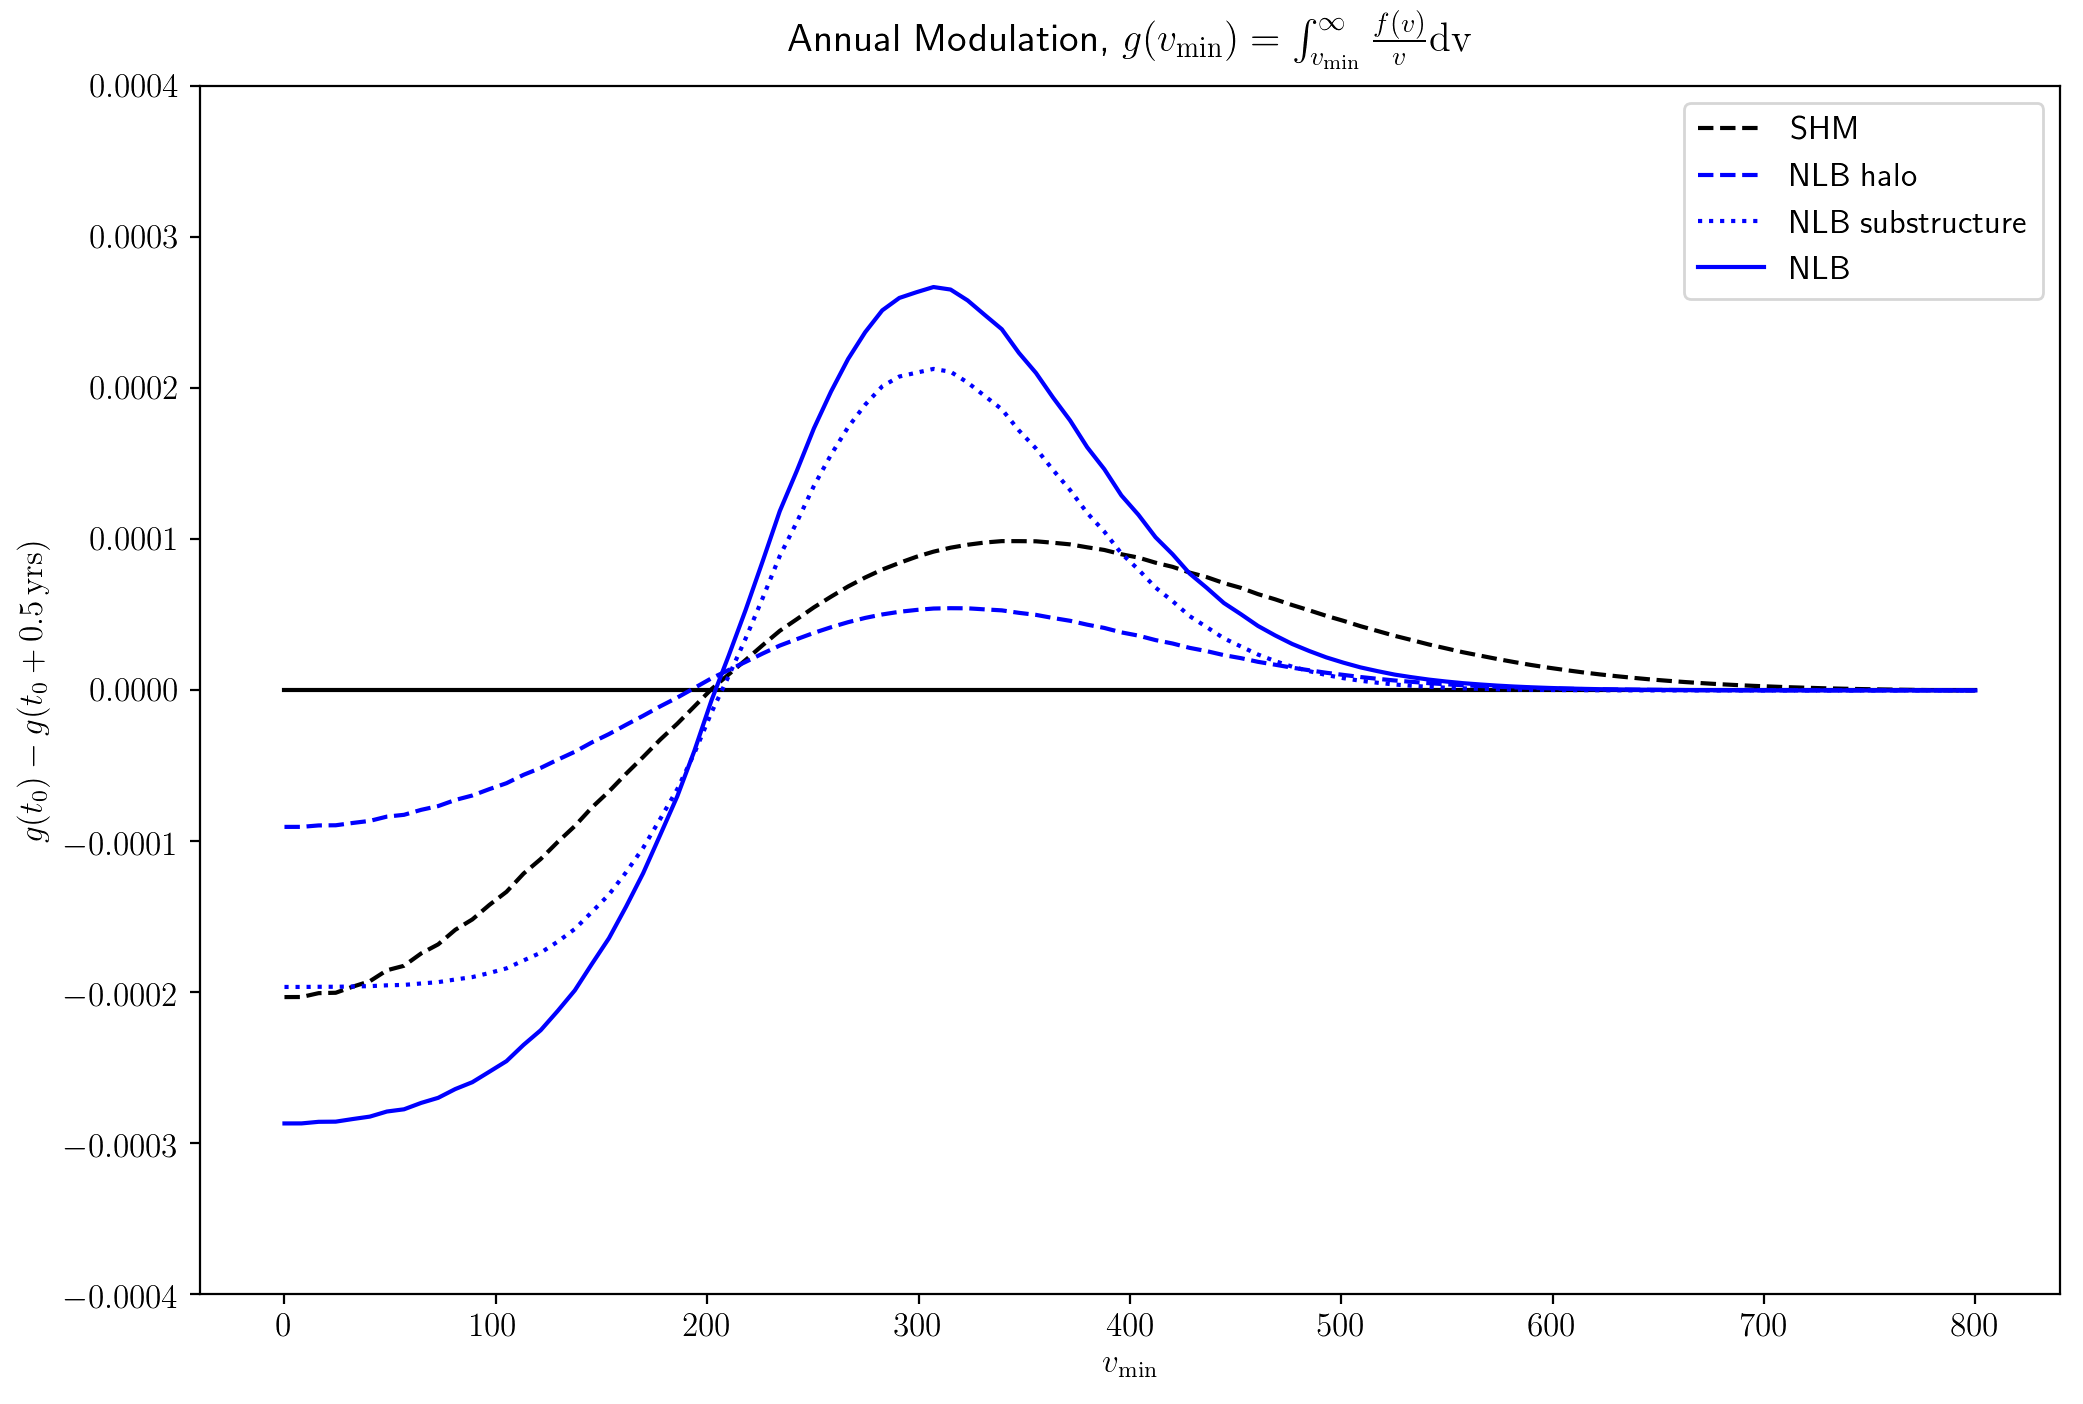

In [292]:
min_v_plot = np.linspace(0.,800.,100)
plt.rcParams["figure.figsize"] = (12, 8)

plt.plot(min_v_plot, np.zeros_like(min_v_plot), color='black')
plt.plot(min_v_plot, int_velDM0_shm_Dec(min_v_plot)-int_velDM0_shm_Jun(min_v_plot), linestyle='dashed', color='black', label='SHM')
plt.plot(min_v_plot, (1.-nlb_eta)*(int_velDM0_halo_nlb_full_Dec(min_v_plot)-int_velDM0_halo_nlb_full_Jun(min_v_plot)), color='blue', linestyle='dashed', label='NLB halo')
plt.plot(min_v_plot, nlb_eta*(int_velDM0_subst_nlb_full_Dec(min_v_plot)-int_velDM0_subst_nlb_full_Jun(min_v_plot)), color='blue', linestyle='dotted', label='NLB substructure')
plt.plot(min_v_plot, (1.-nlb_eta)*int_velDM0_halo_nlb_full_Dec(min_v_plot)+nlb_eta*int_velDM0_subst_nlb_full_Dec(min_v_plot)\
             -nlb_eta*int_velDM0_subst_nlb_full_Jun(min_v_plot)-(1.-nlb_eta)*int_velDM0_halo_nlb_full_Jun(min_v_plot), color='blue', label='NLB')
plt.title("Annual Modulation, $g(v_{\\rm{min}}) = \int^\infty_{v_{\\rm{min}}}\\frac{f(v)}{v}\\rm{d}v$")
plt.xlabel("$v_{\\rm{min}}$"); plt.ylabel("$g(t_0) - g(t_0 + 0.5 \, \\rm{yrs}) $"); plt.ylim((-0.0004, 0.0004)); plt.legend();
plt.show()

## Result analysis

### Constraining DM properties

In [297]:
min_mass = 5.0
max_mass = 200.
grid_mass_pts = 100
h1_low_sigma= -8.0
h1_high_sigma= -4.5
l1_low_sigma= -11.0
l1_high_sigma= -5.5
h2_low_sigma= -7.0
h2_high_sigma= -3.0
l2_low_sigma= -9.0
l2_high_sigma= -4.0

### Maximum gap method

In [298]:
def intervals_func(experiment):
    if (experiment == 'CDMS'):
        return np.array([[12.3, 15.5], [15.5, 100.0]])
    if (experiment == 'Xenon_1T'):
        return np.array([[4.9, 40.9], [40.9, 100.0]])

In [299]:
def counts_func(ER_min, ER_max, mDM, coup, med, spin='SI', steps=100, experiment='CDMS', v_funct='default'):
    #for calculating total counts and maximum gap; ER in keV
    
    exposure= exposure_func(experiment)
    ER_array= np.linspace(ER_min, ER_max, steps)
    rec_rate_array= [exposure*dRT_dER_fan(x*keVtoGeV, mDM, coup, med, spin, experiment, acceptance=True, v_funct=v_funct) for x in ER_array]
    
    return simps(rec_rate_array, ER_array)

In [300]:
def max_gap_tot_counts_func(mDM, coup, med, spin='SI', steps=100, experiment='CDMS',v_funct='default'):
    
    exp_intervals= intervals_func(experiment)
    tot_counts= 0
    max_gap= 0

    for i in xrange(len(exp_intervals)):
        temp_count= counts_func(exp_intervals[i, 0], exp_intervals[i, 1], mDM, coup, med, spin, v_funct=v_funct)
        tot_counts+= temp_count
        if (temp_count > max_gap):
            max_gap= temp_count
    
    return max_gap, tot_counts

In [301]:
"%.2E, %.2E"%max_gap_tot_counts_func(mDM=150, coup=pow(10, -6.9), med='h1')

'2.40E+01, 2.54E+01'

In [302]:
"%.2E, %.2E"%max_gap_tot_counts_func(mDM=25, coup=pow(10, -9), med='l1')

'6.24E+01, 1.18E+02'

In [303]:
def C0_func(x, mu):
    #maximum gap probability distribution following S. Yellin phyiscs/0203002

    if (mu <= 0):
        if (x < 1):
            return 0.0
        else:
            return 1.0
    elif (x > mu):
        return 1.0
    elif ((x< 0.03*mu and mu< 60.0) or (x < 1.8 and mu >= 60.0) or (x < 4.0 and mu >= 700.0)):
        return 0.0
    elif (x != mu):
        lim= np.int(math.floor(mu/x))
        return np.sum([pow((k*x - mu), k-1)*np.exp(-k*x)*(k*x - mu - k)/math.factorial(k) for k in xrange(0, lim+1)]) 
        #factorials over 170 don't like being converted to float; so might want to add an extra if condition 
    else:
        lim= np.int(math.floor(mu/x))
        return 1 - np.exp(-x) + np.sum([pow((k*x - mu), k-1)*np.exp(-k*x)*(k*x - mu - k)/math.factorial(k) for k in xrange(2, lim+1)])

In [304]:
def exclusion_contour(len_sigma_grid, len_mdm_grid, med, experiment, v_funct):
    #function for plotting exclusion curve in DM coupling-mass space
    
    if (med == 'h1'):
        low_sigma= h1_low_sigma
        high_sigma= h1_high_sigma
    elif (med == 'l1'):
        low_sigma= l1_low_sigma
        high_sigma= l1_high_sigma
    elif (med == 'h2'):
        low_sigma= h2_low_sigma
        high_sigma= h2_high_sigma
    elif (med == 'l2'):
        low_sigma= l2_low_sigma
        high_sigma= l2_high_sigma

    max_pt = int(np.log(max_mass)/np.log(1.25))+1
        
    log_sigma_h1_grid= np.linspace(low_sigma, high_sigma, len_sigma_grid)
    temp_grid= np.linspace(0, max_pt, len_mdm_grid)
    mDM_grid= np.array([min_mass*pow(1.25, k) for k in temp_grid])
    
    mesh_grid= np.array([[i, j] for i in mDM_grid for j in log_sigma_h1_grid])
    max_gap_tot_events_grid= np.zeros(len(mesh_grid))
    C0_grid= np.zeros(len(mesh_grid))
    
    max_gap_tot_events_grid= np.array([max_gap_tot_counts_func(mDM= mesh_grid[i, 0], coup=pow(10, mesh_grid[i, 1]),\
                                            med=med, experiment=experiment, v_funct=v_funct) \
                                    for i in xrange(len(mesh_grid))])
    C0_grid= np.array([C0_func(max_gap_tot_events_grid[i, 0], max_gap_tot_events_grid[i, 1]) for i in xrange(len(mesh_grid))])
    
    interp_log_sigma_h1_grid= np.linspace(low_sigma, high_sigma, 50)

    interp_temp_grid= np.linspace(0, max_pt, grid_mass_pts)
    interp_mDM_grid= np.array([min_mass*pow(1.25, k) for k in interp_temp_grid])
    
    interp_C0_grid= griddata(mesh_grid, C0_grid, (interp_mDM_grid[None, :], interp_log_sigma_h1_grid[:, None]), method='linear')
    
    return interp_C0_grid

In [305]:
interp_log_sigma_h1_grid= np.linspace(h1_low_sigma, h1_high_sigma, 50)
interp_log_sigma_l1_grid= np.linspace(l1_low_sigma, l1_high_sigma, 50)
interp_log_sigma_h2_grid= np.linspace(h2_low_sigma, h2_high_sigma, 50)
interp_log_sigma_l2_grid= np.linspace(l2_low_sigma, l2_high_sigma, 50)
max_pt = int(np.log(max_mass)/np.log(1.25))+1
interp_temp_grid= np.linspace(0, max_pt, grid_mass_pts)
interp_mDM_grid= np.array([min_mass*pow(1.25, k) for k in interp_temp_grid])

In [306]:
"""print "generating analytic contours"
interp_C0_h1_grid_analytic = exclusion_contour(40, 50, 'h1', 'CDMS', v_funct= 'default_analytic') #takes about ~30s per coupling
interp_C0_l1_grid_analytic = exclusion_contour(40, 50, 'l1', 'CDMS', v_funct= 'default_analytic')
interp_C0_h2_grid_analytic = exclusion_contour(40, 50, 'h2', 'CDMS', v_funct= 'default_analytic')
interp_C0_l2_grid_analytic = exclusion_contour(40, 50, 'l2', 'CDMS', v_funct= 'default_analytic')"""
print "generating SHM contours"
interp_C0_h1_grid_SHM = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'SHM') 
interp_C0_l1_grid_SHM = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'SHM')
interp_C0_h2_grid_SHM = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'SHM')
interp_C0_l2_grid_SHM = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'SHM')
"""print "generating SHM++ contours"
interp_C0_h1_grid_SHMpp = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'SHM++') 
interp_C0_l1_grid_SHMpp = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'SHM++')
interp_C0_h2_grid_SHMpp = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'SHM++')
interp_C0_l2_grid_SHMpp = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'SHM++')
print "generating SHM++ halo contours"
interp_C0_h1_grid_halo = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'halo++') 
interp_C0_l1_grid_halo = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'halo++')
interp_C0_h2_grid_halo = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'halo++')
interp_C0_l2_grid_halo = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'halo++')
print "generating SHM++ sausage contours"
interp_C0_h1_grid_ssg = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'sausage++') 
interp_C0_l1_grid_ssg = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'sausage++')
interp_C0_h2_grid_ssg = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'sausage++')
interp_C0_l2_grid_ssg = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'sausage++')"""
print "generating NLB contours"
interp_C0_h1_grid_NLB = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB') 
interp_C0_l1_grid_NLB = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB')
interp_C0_h2_grid_NLB = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB')
interp_C0_l2_grid_NLB = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB')
"""print "generating NLB halo contours"
interp_C0_h1_grid_NLB_halo = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_halo') 
interp_C0_l1_grid_NLB_halo = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_halo')
interp_C0_h2_grid_NLB_halo = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_halo')
interp_C0_l2_grid_NLB_halo = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_halo')
print "generating NLB substructure contours"
interp_C0_h1_grid_NLB_subst = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_subst') 
interp_C0_l1_grid_NLB_subst = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_subst')
interp_C0_h2_grid_NLB_subst = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_subst')
interp_C0_l2_grid_NLB_subst = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_subst')"""
print "generating NLB full contours"
interp_C0_h1_grid_NLB_full = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_full') 
interp_C0_l1_grid_NLB_full = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_full')
interp_C0_h2_grid_NLB_full = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_full')
interp_C0_l2_grid_NLB_full = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_full')
"""print "generating NLB halo full contours"
interp_C0_h1_grid_NLB_halo_full = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_halo_full') 
interp_C0_l1_grid_NLB_halo_full = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_halo_full')
interp_C0_h2_grid_NLB_halo_full = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_halo_full')
interp_C0_l2_grid_NLB_halo_full = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_halo_full')
print "generating NLB substructure full contours"
interp_C0_h1_grid_NLB_subst_full = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_subst_full') 
interp_C0_l1_grid_NLB_subst_full = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_subst_full')
interp_C0_h2_grid_NLB_subst_full = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_subst_full')
interp_C0_l2_grid_NLB_subst_full = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_subst_full')"""
print "generating NLB full Jun contours"
interp_C0_h1_grid_NLB_full_Jun = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_full_Jun') 
interp_C0_l1_grid_NLB_full_Jun = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_full_Jun')
interp_C0_h2_grid_NLB_full_Jun = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_full_Jun')
interp_C0_l2_grid_NLB_full_Jun = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_full_Jun')
"""print "generating NLB halo full Jun contours"
interp_C0_h1_grid_NLB_halo_full_Jun = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_halo_full_Jun') 
interp_C0_l1_grid_NLB_halo_full_Jun = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_halo_full_Jun')
interp_C0_h2_grid_NLB_halo_full_Jun = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_halo_full_Jun')
interp_C0_l2_grid_NLB_halo_full_Jun = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_halo_full_Jun')
print "generating NLB substructure full Jun contours"
interp_C0_h1_grid_NLB_subst_full_Jun = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_subst_full_Jun') 
interp_C0_l1_grid_NLB_subst_full_Jun = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_subst_full_Jun')
interp_C0_h2_grid_NLB_subst_full_Jun = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_subst_full_Jun')
interp_C0_l2_grid_NLB_subst_full_Jun = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_subst_full_Jun')"""
print "generating NLB full Dec contours"
interp_C0_h1_grid_NLB_full_Dec = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_full_Dec') 
interp_C0_l1_grid_NLB_full_Dec = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_full_Dec')
interp_C0_h2_grid_NLB_full_Dec = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_full_Dec')
interp_C0_l2_grid_NLB_full_Dec = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_full_Dec')
"""print "generating NLB halo full Dec contours"
interp_C0_h1_grid_NLB_halo_full_Dec = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_halo_full_Dec') 
interp_C0_l1_grid_NLB_halo_full_Dec = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_halo_full_Dec')
interp_C0_h2_grid_NLB_halo_full_Dec = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_halo_full_Dec')
interp_C0_l2_grid_NLB_halo_full_Dec = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_halo_full_Dec')
print "generating NLB substructure full Dec contours"
interp_C0_h1_grid_NLB_subst_full_Dec = exclusion_contour(40, grid_mass_pts, 'h1', 'CDMS', v_funct= 'NLB_subst_full_Dec') 
interp_C0_l1_grid_NLB_subst_full_Dec = exclusion_contour(40, grid_mass_pts, 'l1', 'CDMS', v_funct= 'NLB_subst_full_Dec')
interp_C0_h2_grid_NLB_subst_full_Dec = exclusion_contour(40, grid_mass_pts, 'h2', 'CDMS', v_funct= 'NLB_subst_full_Dec')
interp_C0_l2_grid_NLB_subst_full_Dec = exclusion_contour(40, grid_mass_pts, 'l2', 'CDMS', v_funct= 'NLB_subst_full_Dec')"""
print "complete!"

generating SHM contours
generating NLB contours
generating NLB full contours
generating NLB full Jun contours
generating NLB full Dec contours
complete!


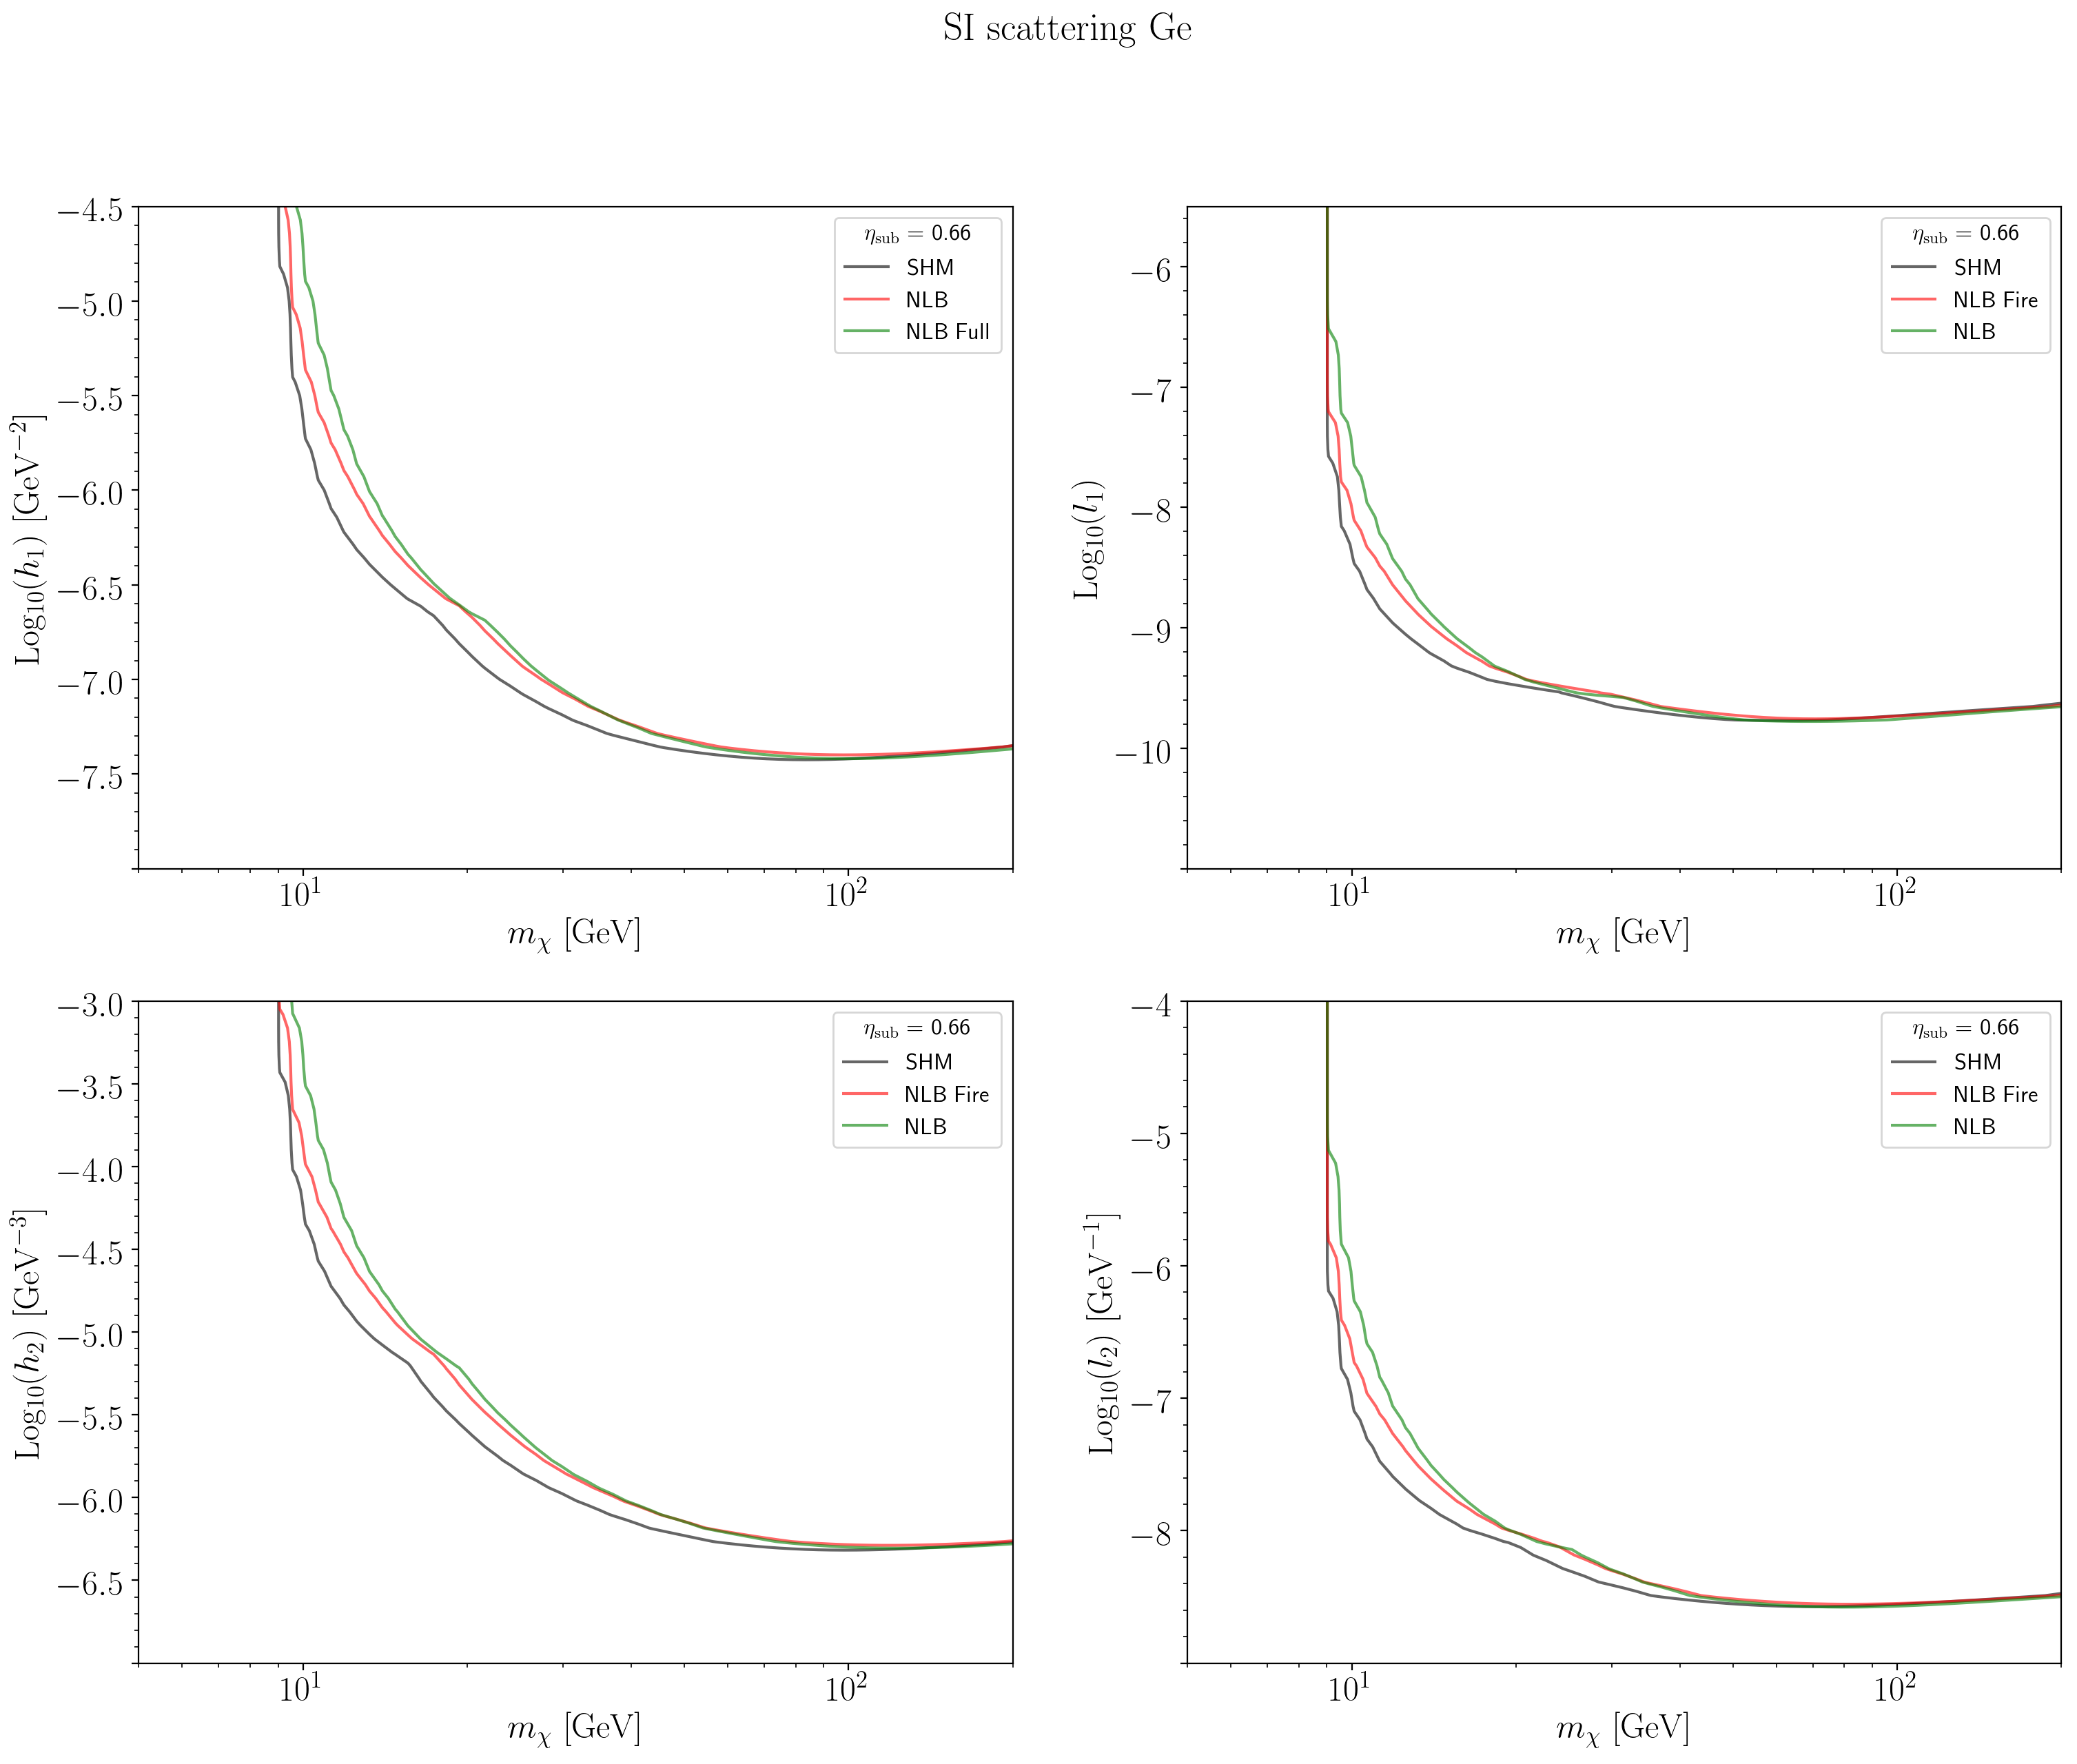

In [307]:
eta = nlb_eta

plt.rcParams["figure.figsize"] = (18, 14)
fig, ax= plt.subplots(2, 2)
#ah1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_analytic, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM (analytic)')
bh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_SHM, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM')
#ch1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_SHMpp, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='SHM++')
#dh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_halo, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='SHM++ Halo')
#eh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_ssg, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='SHM++ Sausage')
xh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB, levels=[0.9], alpha=0.6, colors='red', linestyles='solid', label='NLB')
#yh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_halo, levels=[0.9], alpha=0.6, colors='red', linestyles='dashed', label='NLB Halo')
#zh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_subst, levels=[0.9], alpha=0.6, colors='red', linestyles='dotted', label='NLB Substructure')
xh1a=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_full, levels=[0.9], alpha=0.6, colors='green', linestyles='solid', label='NLB')
#yh1a=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_halo_full, levels=[0.9], alpha=0.6, colors='green', linestyles='dashed', label='NLB Halo Full')
#zh1a=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_subst_full, levels=[0.9], alpha=0.6, colors='green', linestyles='dotted', label='NLB Substructure Full')
#xh1b=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='NLB Full')
#yh1b=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_halo_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='NLB Halo Full Jun')
#zh1b=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_subst_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='NLB Substructure Full Jun')
#xh1c=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='solid', label='NLB Full Dec')
#yh1c=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_halo_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='dashed', label='NLB Halo Full Dec')
#zh1c=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_subst_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='dotted', label='NLB Substructure Full Dec')
#ah1.collections[0].set_label('SHM (analytic)');
bh1.collections[0].set_label('SHM');
#ch1.collections[0].set_label('SHM++')
#dh1.collections[0].set_label('SHM++ Halo');
#eh1.collections[0].set_label('SHM++ Sausage');
xh1.collections[0].set_label('NLB')
#yh1.collections[0].set_label('NLB Halo');
#zh1.collections[0].set_label('NLB Substructure');
xh1a.collections[0].set_label('NLB Full')
#yh1a.collections[0].set_label('NLB Halo Full');
#zh1a.collections[0].set_label('NLB Substructure Full');
#xh1b.collections[0].set_label('NLB Jun')
#yh1b.collections[0].set_label('NLB Halo Jun');
#zh1b.collections[0].set_label('NLB Substructure Jun');
#xh1c.collections[0].set_label('NLB Dec')
#yh1c.collections[0].set_label('NLB Halo Dec');
#zh1c.collections[0].set_label('NLB Substructure Dec');
ax[0, 0].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[0, 0].set_xlim(min_mass, max_mass);
ax[0, 0].set_xscale('log')
ax[0, 0].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[0, 0].set_ylabel(r"${\rm Log_{10}}(h_1) \ {\rm [GeV^{-2}]}$", fontsize=18)
ax[0, 0].set_ylim(h1_low_sigma, h1_high_sigma)
ax[0, 0].minorticks_on();
ax[0, 0].tick_params(axis='both', which='major', labelsize=18)
ax[0, 0].tick_params(axis='both', which='minor', labelsize=16)
plt.setp(ax[0, 0].get_yticklabels()[0], visible=False)

#al1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_analytic, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM (analytic)')
bl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_SHM, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM')
#cl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_SHMpp, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='SHM++')
#dl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_halo, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='SHM++ Halo')
#el1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_ssg, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='SHM++ Sausage')
xl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB, levels=[0.9], alpha=0.6, colors='red', linestyles='solid', label='NLB')
#yl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_halo, levels=[0.9], alpha=0.6, colors='red', linestyles='dashed', label='NLB Halo')
#zl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_subst, levels=[0.9], alpha=0.6, colors='red', linestyles='dotted', label='NLB Substructure')
xl1a=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_full, levels=[0.9], alpha=0.6, colors='green', linestyles='solid', label='NLB')
#yl1a=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_halo_full, levels=[0.9], alpha=0.6, colors='green', linestyles='dashed', label='NLB Halo Full')
#zl1a=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_subst_full, levels=[0.9], alpha=0.6, colors='green', linestyles='dotted', label='NLB Substructure Full')
#xl1b=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='NLB Full')
#yl1b=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_halo_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='NLB Halo Full Jun')
#zl1b=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_subst_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='NLB Substructure Full Jun')
#xl1c=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='solid', label='NLB Full Dec')
#yl1c=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_halo_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='dashed', label='NLB Halo Full Dec')
#zl1c=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_subst_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='dotted', label='NLB Substructure Full Dec')
#al1.collections[0].set_label('SHM (analytic)');
bl1.collections[0].set_label('SHM');
#cl1.collections[0].set_label('SHM++')
#dl1.collections[0].set_label('SHM++ Halo');
#el1.collections[0].set_label('SHM++ Sausage');
xl1.collections[0].set_label('NLB Fire')
#yl1.collections[0].set_label('NLB Halo');
#zl1.collections[0].set_label('NLB Substructure');
xl1a.collections[0].set_label('NLB')
#yl1a.collections[0].set_label('NLB Halo Full');
#zl1a.collections[0].set_label('NLB Substructure Full');
#xl1b.collections[0].set_label('NLB Jun')
#yl1b.collections[0].set_label('NLB Halo Jun');
#zl1b.collections[0].set_label('NLB Substructure Jun');
#xl1c.collections[0].set_label('NLB Dec')
#yl1c.collections[0].set_label('NLB Halo Dec');
#zl1c.collections[0].set_label('NLB Substructure Dec');
ax[0, 1].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[0, 1].set_xlim(min_mass, max_mass);
ax[0, 1].set_xscale('log')
ax[0, 1].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[0, 1].set_ylabel(r"${\rm Log_{10}}(l_1)$", fontsize=18)
ax[0, 1].set_ylim(l1_low_sigma, l1_high_sigma);
ax[0, 1].minorticks_on();
ax[0, 1].tick_params(axis='both', which='major', labelsize=18)
ax[0, 1].tick_params(axis='both', which='minor', labelsize=16)
plt.setp(ax[0, 1].get_yticklabels()[0], visible=False) 

#ah2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_analytic, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM (analytic)')
bh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_SHM, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM')
#ch2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_SHMpp, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='SHM++')
#dh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_halo, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='SHM++ Halo')
#eh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_ssg, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='SHM++ Sausage')
xh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB, levels=[0.9], alpha=0.6, colors='red', linestyles='solid', label='NLB')
#yh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_halo, levels=[0.9], alpha=0.6, colors='red', linestyles='dashed', label='NLB Halo')
#zh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_subst, levels=[0.9], alpha=0.6, colors='red', linestyles='dotted', label='NLB Substructure')
xh2a=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_full, levels=[0.9], alpha=0.6, colors='green', linestyles='solid', label='NLB')
#yh2a=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_halo_full, levels=[0.9], alpha=0.6, colors='green', linestyles='dashed', label='NLB Halo Full')
#zh2a=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_subst_full, levels=[0.9], alpha=0.6, colors='green', linestyles='dotted', label='NLB Substructure Full')
#xh2b=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='NLB Full')
#yh2b=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_halo_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='NLB Halo Full Jun')
#zh2b=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_subst_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='NLB Substructure Full Jun')
#xh2c=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='solid', label='NLB Full Dec')
#yh2c=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_halo_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='dashed', label='NLB Halo Full Dec')
#zh2c=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_subst_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='dotted', label='NLB Substructure Full Dec')
#ah2.collections[0].set_label('SHM (analytic)');
bh2.collections[0].set_label('SHM');
#ch2.collections[0].set_label('SHM++')
#dh2.collections[0].set_label('SHM++ Halo');
#eh2.collections[0].set_label('SHM++ Sausage');
xh2.collections[0].set_label('NLB Fire')
#yh2.collections[0].set_label('NLB Halo');
#zh2.collections[0].set_label('NLB Substructure');
xh2a.collections[0].set_label('NLB')
#yh2a.collections[0].set_label('NLB Halo Full');
#zh2a.collections[0].set_label('NLB Substructure Full');
#xh2b.collections[0].set_label('NLB Jun')
#yh2b.collections[0].set_label('NLB Halo Jun');
#zh2b.collections[0].set_label('NLB Substructure Jun');
#xh2c.collections[0].set_label('NLB Dec')
#yh2c.collections[0].set_label('NLB Halo Dec');
#zh2c.collections[0].set_label('NLB Substructure Dec');
ax[1, 0].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[1, 0].set_xlim(min_mass, max_mass);
ax[1, 0].set_xscale('log')
ax[1, 0].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[1, 0].set_ylabel(r"${\rm Log_{10}}(h_2) \ {\rm [GeV^{-3}]}$", fontsize=18)
ax[1, 0].set_ylim(h2_low_sigma, h2_high_sigma)
ax[1, 0].minorticks_on();
ax[1, 0].tick_params(axis='both', which='major', labelsize=18)
ax[1, 0].tick_params(axis='both', which='minor', labelsize=16)
plt.setp(ax[1, 0].get_yticklabels()[0], visible=False)

#al2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_analytic, levels=[0.9], alpha=0.6, colors='black', linestyles='solid')
bl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_SHM, levels=[0.9], alpha=0.6, colors='black', linestyles='solid')
#cl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_SHMpp, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid')
#dl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_halo, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed')
#el2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_ssg, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted')
xl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB, levels=[0.9], alpha=0.6, colors='red', linestyles='solid', label='NLB')
#yl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_halo, levels=[0.9], alpha=0.6, colors='red', linestyles='dashed', label='NLB Halo')
#zl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_subst, levels=[0.9], alpha=0.6, colors='red', linestyles='dotted', label='NLB Substructure')
xl2a=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_full, levels=[0.9], alpha=0.6, colors='green', linestyles='solid', label='NLB')
#yl2a=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_halo_full, levels=[0.9], alpha=0.6, colors='green', linestyles='dashed', label='NLB Halo Full')
#zl2a=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_subst_full, levels=[0.9], alpha=0.6, colors='green', linestyles='dotted', label='NLB Substructure Full')
#xl2b=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='NLB Full')
#yl2b=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_halo_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='NLB Halo Full Jun')
#zl2b=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_subst_full_Jun, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='NLB Substructure Full Jun')
#xl2c=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='solid', label='NLB Full Dec')
#yl2c=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_halo_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='dashed', label='NLB Halo Full Dec')
#zl2c=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_subst_full_Dec, levels=[0.9], alpha=0.6, colors='violet', linestyles='dotted', label='NLB Substructure Full Dec')
#al2.collections[0].set_label('SHM (analytic)');
bl2.collections[0].set_label('SHM');
#cl2.collections[0].set_label('SHM++')
#dl2.collections[0].set_label('SHM++ Halo');
#el2.collections[0].set_label('SHM++ Sausage');
xl2.collections[0].set_label('NLB Fire')
#yl2.collections[0].set_label('NLB Halo');
#zl2.collections[0].set_label('NLB Substructure');
xl2a.collections[0].set_label('NLB')
#yl2a.collections[0].set_label('NLB Halo Full');
#zl2a.collections[0].set_label('NLB Substructure Full');
#xl2b.collections[0].set_label('NLB Jun')
#yl2b.collections[0].set_label('NLB Halo Jun');
#zl2b.collections[0].set_label('NLB Substructure Jun');
#xl2c.collections[0].set_label('NLB Dec')
#yl2c.collections[0].set_label('NLB Halo Dec');
#zl2c.collections[0].set_label('NLB Substructure Dec');
ax[1, 1].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[1, 1].set_xlim(min_mass, max_mass);
ax[1, 1].set_xscale('log')
ax[1, 1].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[1, 1].set_ylabel(r"${\rm Log_{10}}(l_2) \ {\rm [GeV^{-1}]}$", fontsize=18)
ax[1, 1].set_ylim(l2_low_sigma, l2_high_sigma)
ax[1, 1].minorticks_on();
ax[1, 1].tick_params(axis='both', which='major', labelsize=18)
ax[1, 1].tick_params(axis='both', which='minor', labelsize=16)
plt.setp(ax[1, 1].get_yticklabels()[0], visible=False)
plt.suptitle(r'${\rm SI \ scattering \ Ge}$', fontsize=20);
plt.savefig('exclusion_curve_NLB_si.pdf', bbox_inches='tight');

In [308]:
def scatter_ratio(len_mdm_grid, med, experiment,v_funct_1, v_funct_2):
    #function for plotting exclusion curve in DM coupling-mass space
    
    sigma_midpt = np.nan
    
    if (med == 'h1'):
        sigma_midpt= (h1_low_sigma + h1_high_sigma)/2.
    elif (med == 'l1'):
        sigma_midpt= (l1_low_sigma + l1_high_sigma)/2.
    elif (med == 'h2'):
        sigma_midpt= (h2_low_sigma + h2_high_sigma)/2.
    elif (med == 'l2'):
        sigma_midpt= (l2_low_sigma + l2_high_sigma)/2.

    max_pt = int(np.log(max_mass)/np.log(1.25))+1

    temp_grid= np.linspace(0, max_pt, len_mdm_grid)
    mDM_grid= np.array([min_mass*pow(1.25, k) for k in temp_grid])
    
    max_gap_tot_events_grid_1=  np.array([max_gap_tot_counts_func(mDM= mDM_grid[i], coup=pow(10, sigma_midpt),\
                                            med=med, experiment=experiment, v_funct=v_funct_1)[1] \
                                    for i in range(len(mDM_grid))])
    max_gap_tot_events_grid_2=  np.array([max_gap_tot_counts_func(mDM= mDM_grid[i], coup=pow(10, sigma_midpt),\
                                            med=med, experiment=experiment, v_funct=v_funct_2)[1] \
                                    for i in range(len(mDM_grid))])
    ratio_grid= np.array([max_gap_tot_events_grid_1[i]/max_gap_tot_events_grid_2[i] for i in range(len(mDM_grid))])

    #interp_temp_grid= np.linspace(0, max_pt, grid_mass_pts)
    #interp_mDM_grid= np.array([min_mass*pow(1.25, k) for k in interp_temp_grid])
    interp_ratio_grid = interp1d(mDM_grid, (np.nan_to_num(ratio_grid)+np.isnan(ratio_grid) ) )
    
    return interp_ratio_grid

def annual_ratio(len_mdm_grid, med, experiment,v_funct_1, v_funct_2, v_funct_3 = None, ratio_inf_to_num = 0.):
    #function for plotting exclusion curve in DM coupling-mass space
    
    sigma_midpt = np.nan
    
    if (med == 'h1'):
        sigma_midpt= (h1_low_sigma + h1_high_sigma)/2.
    elif (med == 'l1'):
        sigma_midpt= (l1_low_sigma + l1_high_sigma)/2.
    elif (med == 'h2'):
        sigma_midpt= (h2_low_sigma + h2_high_sigma)/2.
    elif (med == 'l2'):
        sigma_midpt= (l2_low_sigma + l2_high_sigma)/2.

    max_pt = int(np.log(max_mass)/np.log(1.25))+1

    temp_grid= np.linspace(0, max_pt, len_mdm_grid)
    mDM_grid= np.array([min_mass*pow(1.25, k) for k in temp_grid])

    
    max_gap_tot_events_grid_1=  np.array([max_gap_tot_counts_func(mDM= mDM_grid[i], coup=pow(10, sigma_midpt),\
                                            med=med, experiment=experiment, v_funct=v_funct_1)[1] \
                                    for i in range(len(mDM_grid))])
    max_gap_tot_events_grid_2=  np.array([max_gap_tot_counts_func(mDM= mDM_grid[i], coup=pow(10, sigma_midpt),\
                                            med=med, experiment=experiment, v_funct=v_funct_2)[1] \
                                    for i in range(len(mDM_grid))])
    max_gap_tot_events_grid_3=  np.empty_like(mDM_grid)
    
    if v_funct_3 is None:
        max_gap_tot_events_grid_3=  np.array([ (max_gap_tot_events_grid_1[i] + max_gap_tot_events_grid_2[i]) \
                                    for i in range(len(mDM_grid))])
    else:
        max_gap_tot_events_grid_3=  np.array([max_gap_tot_counts_func(mDM= mDM_grid[i], coup=pow(10, sigma_midpt),\
                                            med=med, experiment=experiment, v_funct=v_funct_3)[1] \
                                    for i in range(len(mDM_grid))])
    ratio_grid= np.array([(max_gap_tot_events_grid_1[i]-max_gap_tot_events_grid_2[i])/\
                          (2.*(max_gap_tot_events_grid_3[i])) for i in range(len(mDM_grid))])

    #interp_temp_grid= np.linspace(0, max_pt, grid_mass_pts)
    #interp_mDM_grid= np.array([min_mass*pow(1.25, k) for k in interp_temp_grid])
    interp_ratio_grid = interp1d(mDM_grid, (np.nan_to_num(ratio_grid)+ratio_inf_to_num*np.isnan(ratio_grid) ) )
    
    return interp_ratio_grid

/Users/john/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in double_scalars


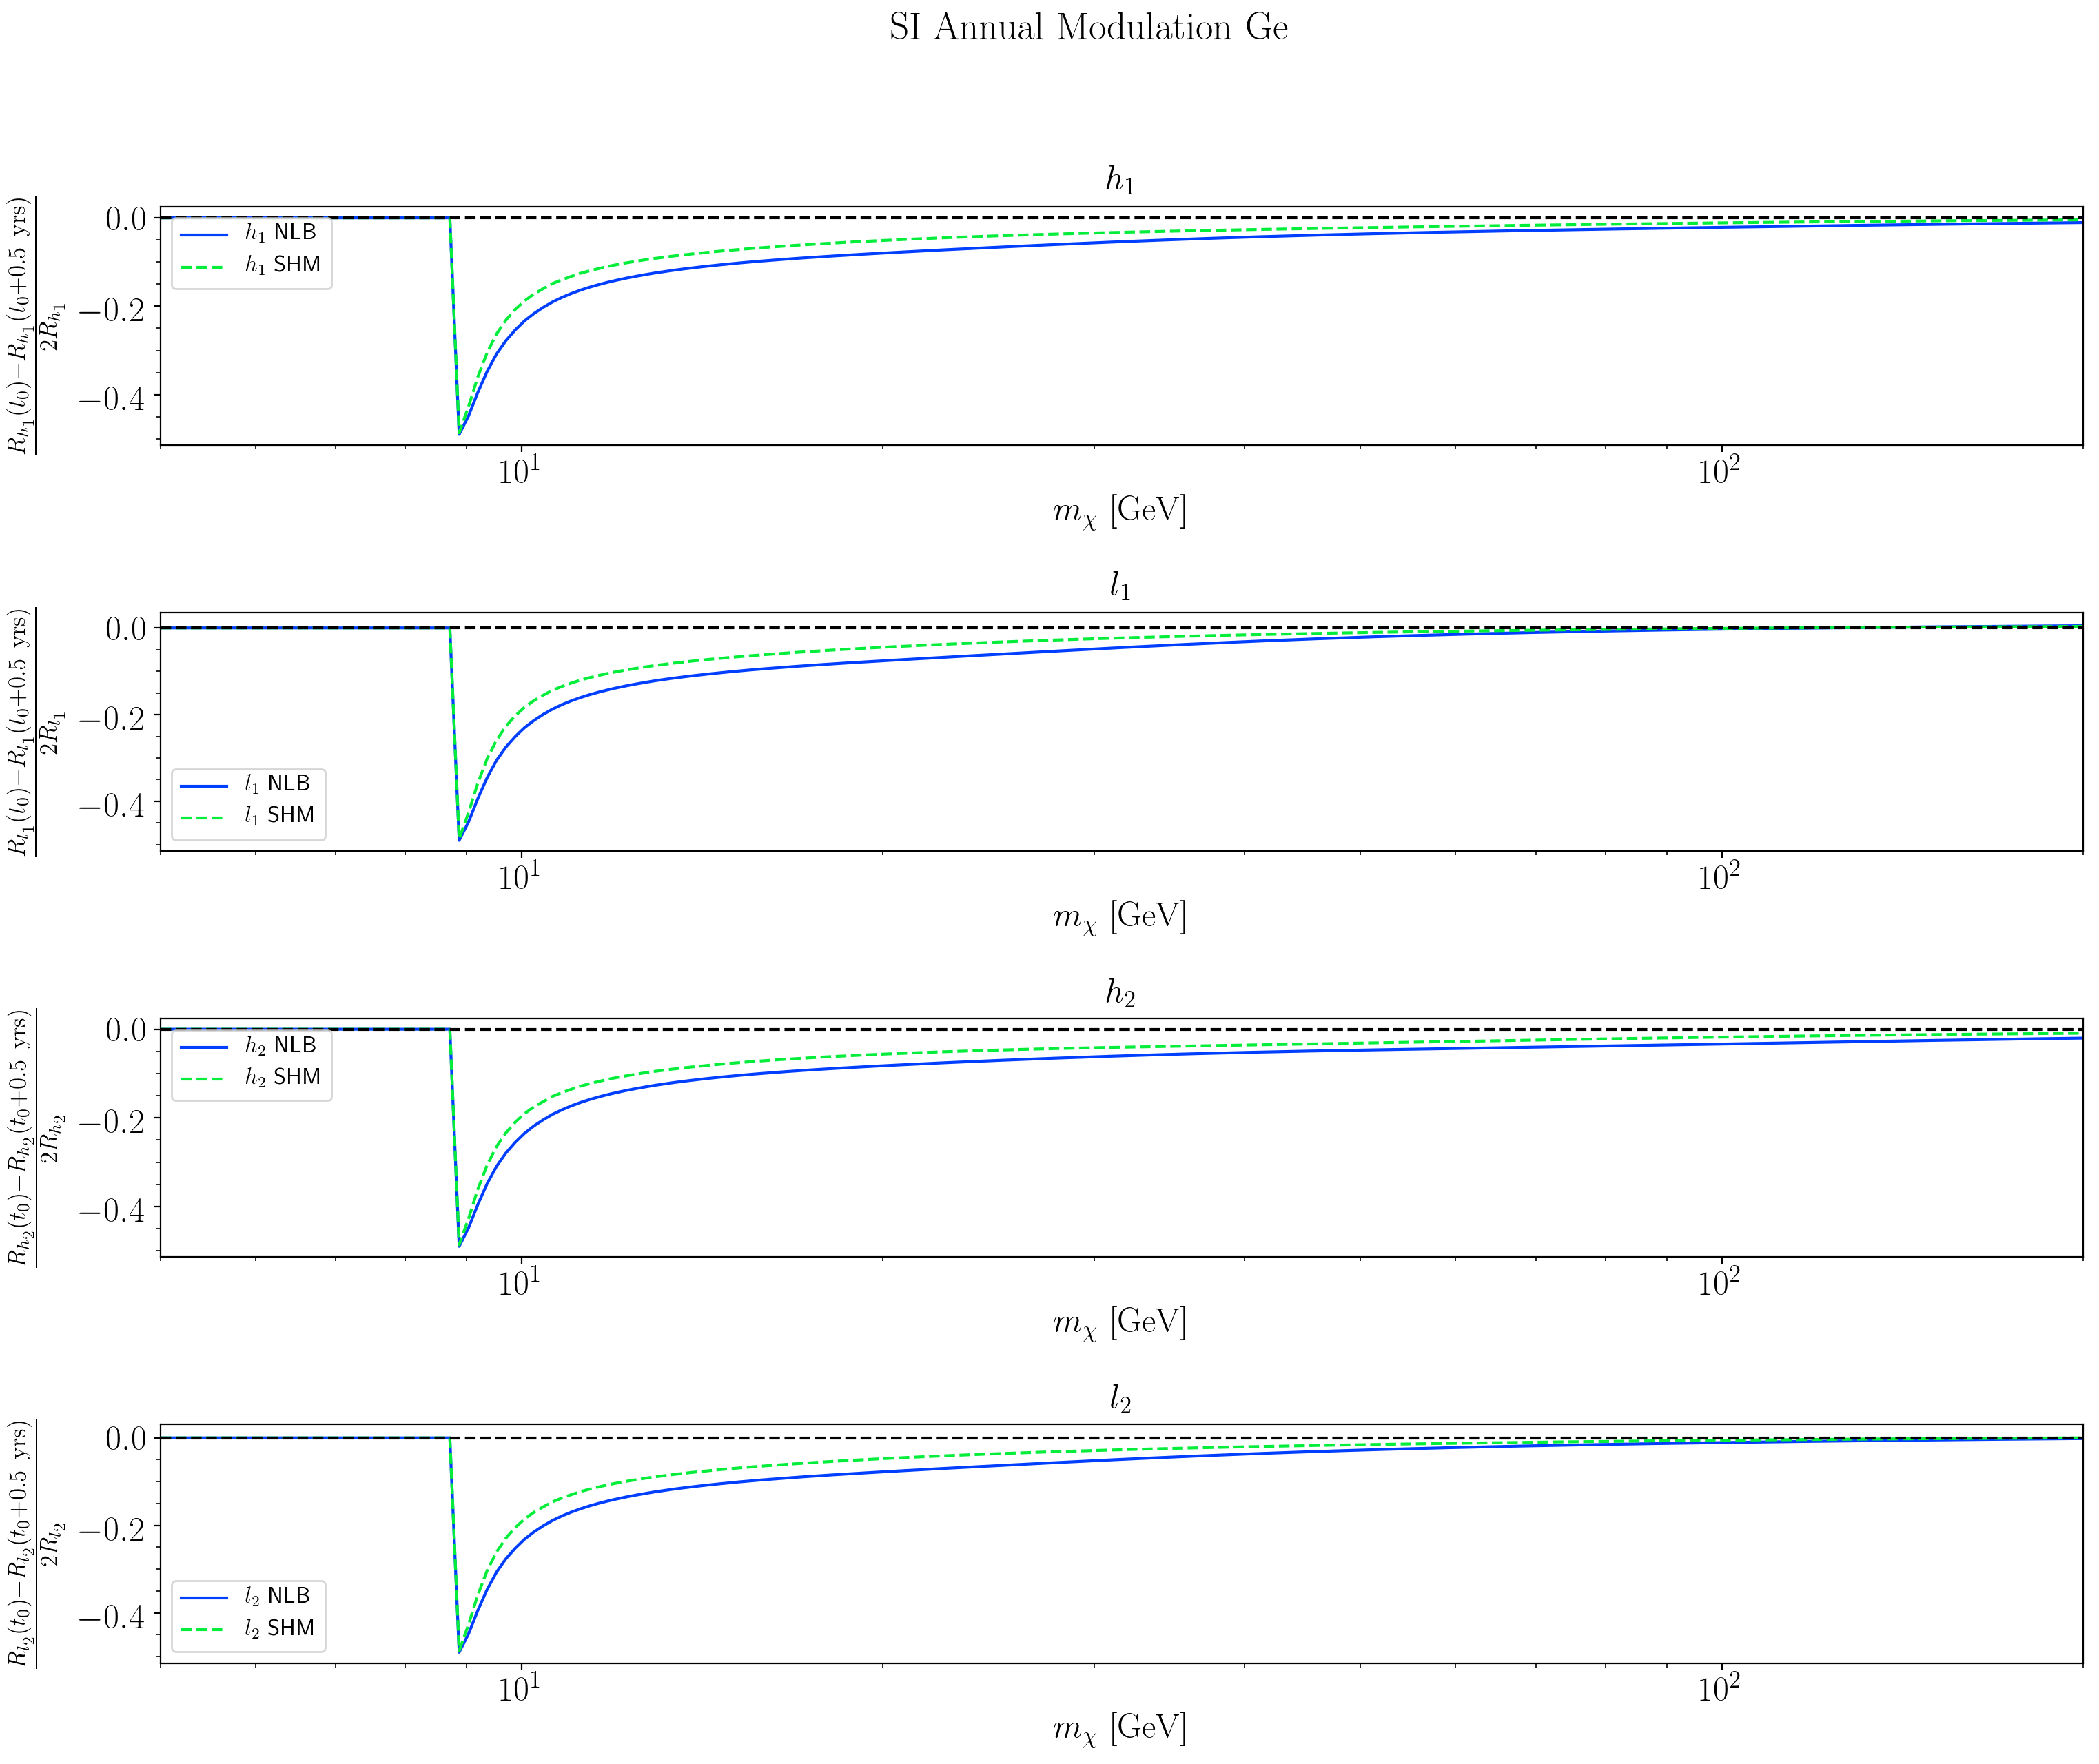

In [315]:
grid_mass_pts = 300
null_ratio = 0.

max_pt = int(np.log(max_mass)/np.log(1.25))+1
temp_grid= np.linspace(0, max_pt, grid_mass_pts)
mDM_grid= np.array([min_mass*pow(1.25, k) for k in temp_grid])


plt.rcParams["figure.figsize"] = (18, 14)
fig, ax= plt.subplots(4, 1)

plt.subplots_adjust(wspace = 0.2, hspace=0.7)

h1_scatter_ratio_NLB = annual_ratio(grid_mass_pts, "h1", "CDMS", "NLB_full_Jun", "NLB_full_Dec", ratio_inf_to_num = null_ratio)
h1_scatter_ratio_SHM = annual_ratio(grid_mass_pts, "h1", "CDMS", "SHM_Jun", "SHM_Dec", ratio_inf_to_num = null_ratio)
ax[0].plot(mDM_grid, h1_scatter_ratio_NLB(mDM_grid), label='$h_1$ NLB');
ax[0].plot(mDM_grid, h1_scatter_ratio_SHM(mDM_grid), linestyle="--", label='$h_1$ SHM');
ax[0].plot(mDM_grid, null_ratio*np.ones_like(mDM_grid), linestyle="--",color="black")
#ax[1, 0].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[0].set_xlim(min_mass, max_mass);
ax[0].set_xscale('log')
ax[0].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[0].set_ylabel(r"$\frac{R_{h_1}(t_0)-R_{h_1}(t_0 + 0.5 \rm{ \ yrs})}{2R_{h_1}}$", fontsize=18)
ax[0].minorticks_on();
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_title("$h_1$", fontsize=18)
ax[0].legend()

l1_scatter_ratio_NLB = annual_ratio(grid_mass_pts, "l1", "CDMS", "NLB_full_Jun", "NLB_full_Dec", ratio_inf_to_num = null_ratio)
l1_scatter_ratio_SHM = annual_ratio(grid_mass_pts, "l1", "CDMS", "SHM_Jun", "SHM_Dec", ratio_inf_to_num = null_ratio)
ax[1].plot(mDM_grid, l1_scatter_ratio_NLB(mDM_grid), label='$l_1$ NLB');
ax[1].plot(mDM_grid, l1_scatter_ratio_SHM(mDM_grid), linestyle="--", label='$l_1$ SHM');
ax[1].plot(mDM_grid, null_ratio*np.ones_like(mDM_grid), linestyle="--",color="black")
#ax[1, 0].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[1].set_xlim(min_mass, max_mass);
ax[1].set_xscale('log')
ax[1].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[1].set_ylabel(r"$\frac{R_{l_1}(t_0)-R_{l_1}(t_0 + 0.5 \rm{ \ yrs})}{2R_{l_1}}$", fontsize=18)
ax[1].minorticks_on();
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_title("$l_1$", fontsize=18)
ax[1].legend()

h2_scatter_ratio_NLB = annual_ratio(grid_mass_pts, "h2", "CDMS", "NLB_full_Jun", "NLB_full_Dec", ratio_inf_to_num = null_ratio)
h2_scatter_ratio_SHM = annual_ratio(grid_mass_pts, "h2", "CDMS", "SHM_Jun", "SHM_Dec", ratio_inf_to_num = null_ratio)
ax[2].plot(mDM_grid, h2_scatter_ratio_NLB(mDM_grid), label='$h_2$ NLB');
ax[2].plot(mDM_grid, h2_scatter_ratio_SHM(mDM_grid), linestyle="--", label='$h_2$ SHM');
ax[2].plot(mDM_grid, null_ratio*np.ones_like(mDM_grid), linestyle="--",color="black")
#ax[1, 0].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[2].set_xlim(min_mass, max_mass);
ax[2].set_xscale('log')
ax[2].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[2].set_ylabel(r"$\frac{R_{h_2}(t_0)-R_{h_2}(t_0 + 0.5 \rm{ \ yrs})}{2R_{h_2}}$", fontsize=18)
ax[2].minorticks_on();
ax[2].tick_params(axis='both', which='major', labelsize=18)
ax[2].set_title("$h_2$", fontsize=18)
ax[2].legend()

l2_scatter_ratio_NLB = annual_ratio(grid_mass_pts, "l2", "CDMS", "NLB_full_Jun", "NLB_full_Dec", ratio_inf_to_num = null_ratio)
l2_scatter_ratio_SHM = annual_ratio(grid_mass_pts, "l2", "CDMS", "SHM_Jun", "SHM_Dec", ratio_inf_to_num = null_ratio)
ax[3].plot(mDM_grid, l2_scatter_ratio_NLB(mDM_grid), label='$l_2$ NLB');
ax[3].plot(mDM_grid, l2_scatter_ratio_SHM(mDM_grid), linestyle="--", label='$l_2$ SHM')
ax[3].plot(mDM_grid, null_ratio*np.ones_like(mDM_grid), linestyle="--",color="black")
#ax[1, 0].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[3].set_xlim(min_mass, max_mass);
ax[3].set_xscale('log')
ax[3].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[3].set_ylabel(r"$\frac{R_{l_2}(t_0)-R_{l_2}(t_0 + 0.5 \rm{ \ yrs})}{2R_{l_2}}$", fontsize=18)
ax[3].minorticks_on();
ax[3].tick_params(axis='both', which='major', labelsize=18)
ax[3].set_title("$l_2$", fontsize=18)
ax[3].legend()

plt.suptitle(r'${\rm SI \ Annual \ Modulation \ Ge}$', fontsize=20);
plt.savefig('annual_modulation_NLB_si.pdf', bbox_inches='tight');
plt.show()


In [310]:
"""print "generating analytic contours"
interp_C0_h1_grid_analytic = exclusion_contour(40, 50, 'h1', 'CDMS', v_funct= 'default_analytic') #takes about ~30s per coupling
interp_C0_l1_grid_analytic = exclusion_contour(40, 50, 'l1', 'CDMS', v_funct= 'default_analytic')
interp_C0_h2_grid_analytic = exclusion_contour(40, 50, 'h2', 'CDMS', v_funct= 'default_analytic')
interp_C0_l2_grid_analytic = exclusion_contour(40, 50, 'l2', 'CDMS', v_funct= 'default_analytic')"""
print "generating SHM contours"
interp_C0_h1_grid_SHM_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'SHM') 
interp_C0_l1_grid_SHM_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'SHM')
interp_C0_h2_grid_SHM_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'SHM')
interp_C0_l2_grid_SHM_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'SHM')
print "generating NLB contours"
interp_C0_h1_grid_NLB_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB') 
interp_C0_l1_grid_NLB_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB')
interp_C0_h2_grid_NLB_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB')
interp_C0_l2_grid_NLB_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB')
"""print "generating NLB halo contours"
interp_C0_h1_grid_NLB_halo_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_halo') 
interp_C0_l1_grid_NLB_halo_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_halo')
interp_C0_h2_grid_NLB_halo_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_halo')
interp_C0_l2_grid_NLB_halo_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_halo')
print "generating NLB substructure contours"
interp_C0_h1_grid_NLB_subst_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_subst') 
interp_C0_l1_grid_NLB_subst_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_subst')
interp_C0_h2_grid_NLB_subst_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_subst')
interp_C0_l2_grid_NLB_subst_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_subst')
"""
print "generating NLB full contours"
interp_C0_h1_grid_NLB_full_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_full') 
interp_C0_l1_grid_NLB_full_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_full')
interp_C0_h2_grid_NLB_full_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_full')
interp_C0_l2_grid_NLB_full_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_full')
"""
print "generating NLB halo full contours"
interp_C0_h1_grid_NLB_halo_full_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_halo_full') 
interp_C0_l1_grid_NLB_halo_full_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_halo_full')
interp_C0_h2_grid_NLB_halo_full_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_halo_full')
interp_C0_l2_grid_NLB_halo_full_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_halo_full')
print "generating NLB substructure full contours"
interp_C0_h1_grid_NLB_subst_full_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_subst_full') 
interp_C0_l1_grid_NLB_subst_full_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_subst_full')
interp_C0_h2_grid_NLB_subst_full_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_subst_full')
interp_C0_l2_grid_NLB_subst_full_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_subst_full')
print "generating NLB full Jun contours"
interp_C0_h1_grid_NLB_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_full_Jun') 
interp_C0_l1_grid_NLB_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_full_Jun')
interp_C0_h2_grid_NLB_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_full_Jun')
interp_C0_l2_grid_NLB_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_full_Jun')
print "generating NLB halo full Jun contours"
interp_C0_h1_grid_NLB_halo_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_halo_full_Jun') 
interp_C0_l1_grid_NLB_halo_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_halo_full_Jun')
interp_C0_h2_grid_NLB_halo_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_halo_full_Jun')
interp_C0_l2_grid_NLB_halo_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_halo_full_Jun')
print "generating NLB substructure full Jun contours"
interp_C0_h1_grid_NLB_subst_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_subst_full_Jun') 
interp_C0_l1_grid_NLB_subst_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_subst_full_Jun')
interp_C0_h2_grid_NLB_subst_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_subst_full_Jun')
interp_C0_l2_grid_NLB_subst_full_Jun_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_subst_full_Jun')
print "generating NLB full Dec contours"
interp_C0_h1_grid_NLB_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_full_Dec') 
interp_C0_l1_grid_NLB_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_full_Dec')
interp_C0_h2_grid_NLB_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_full_Dec')
interp_C0_l2_grid_NLB_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_full_Dec')
print "generating NLB halo full Dec contours"
interp_C0_h1_grid_NLB_halo_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_halo_full_Dec') 
interp_C0_l1_grid_NLB_halo_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_halo_full_Dec')
interp_C0_h2_grid_NLB_halo_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_halo_full_Dec')
interp_C0_l2_grid_NLB_halo_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_halo_full_Dec')
print "generating NLB substructure full Dec contours"
interp_C0_h1_grid_NLB_subst_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'h1', 'Xenon_1T', v_funct= 'NLB_subst_full_Dec') 
interp_C0_l1_grid_NLB_subst_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'l1', 'Xenon_1T', v_funct= 'NLB_subst_full_Dec')
interp_C0_h2_grid_NLB_subst_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'h2', 'Xenon_1T', v_funct= 'NLB_subst_full_Dec')
interp_C0_l2_grid_NLB_subst_full_Dec_Xe = exclusion_contour(40, grid_mass_pts, 'l2', 'Xenon_1T', v_funct= 'NLB_subst_full_Dec')"""
print "complete!"

generating SHM contours
generating NLB contours
generating NLB full contours
complete!


TypeError: Length of x must be number of columns in z.

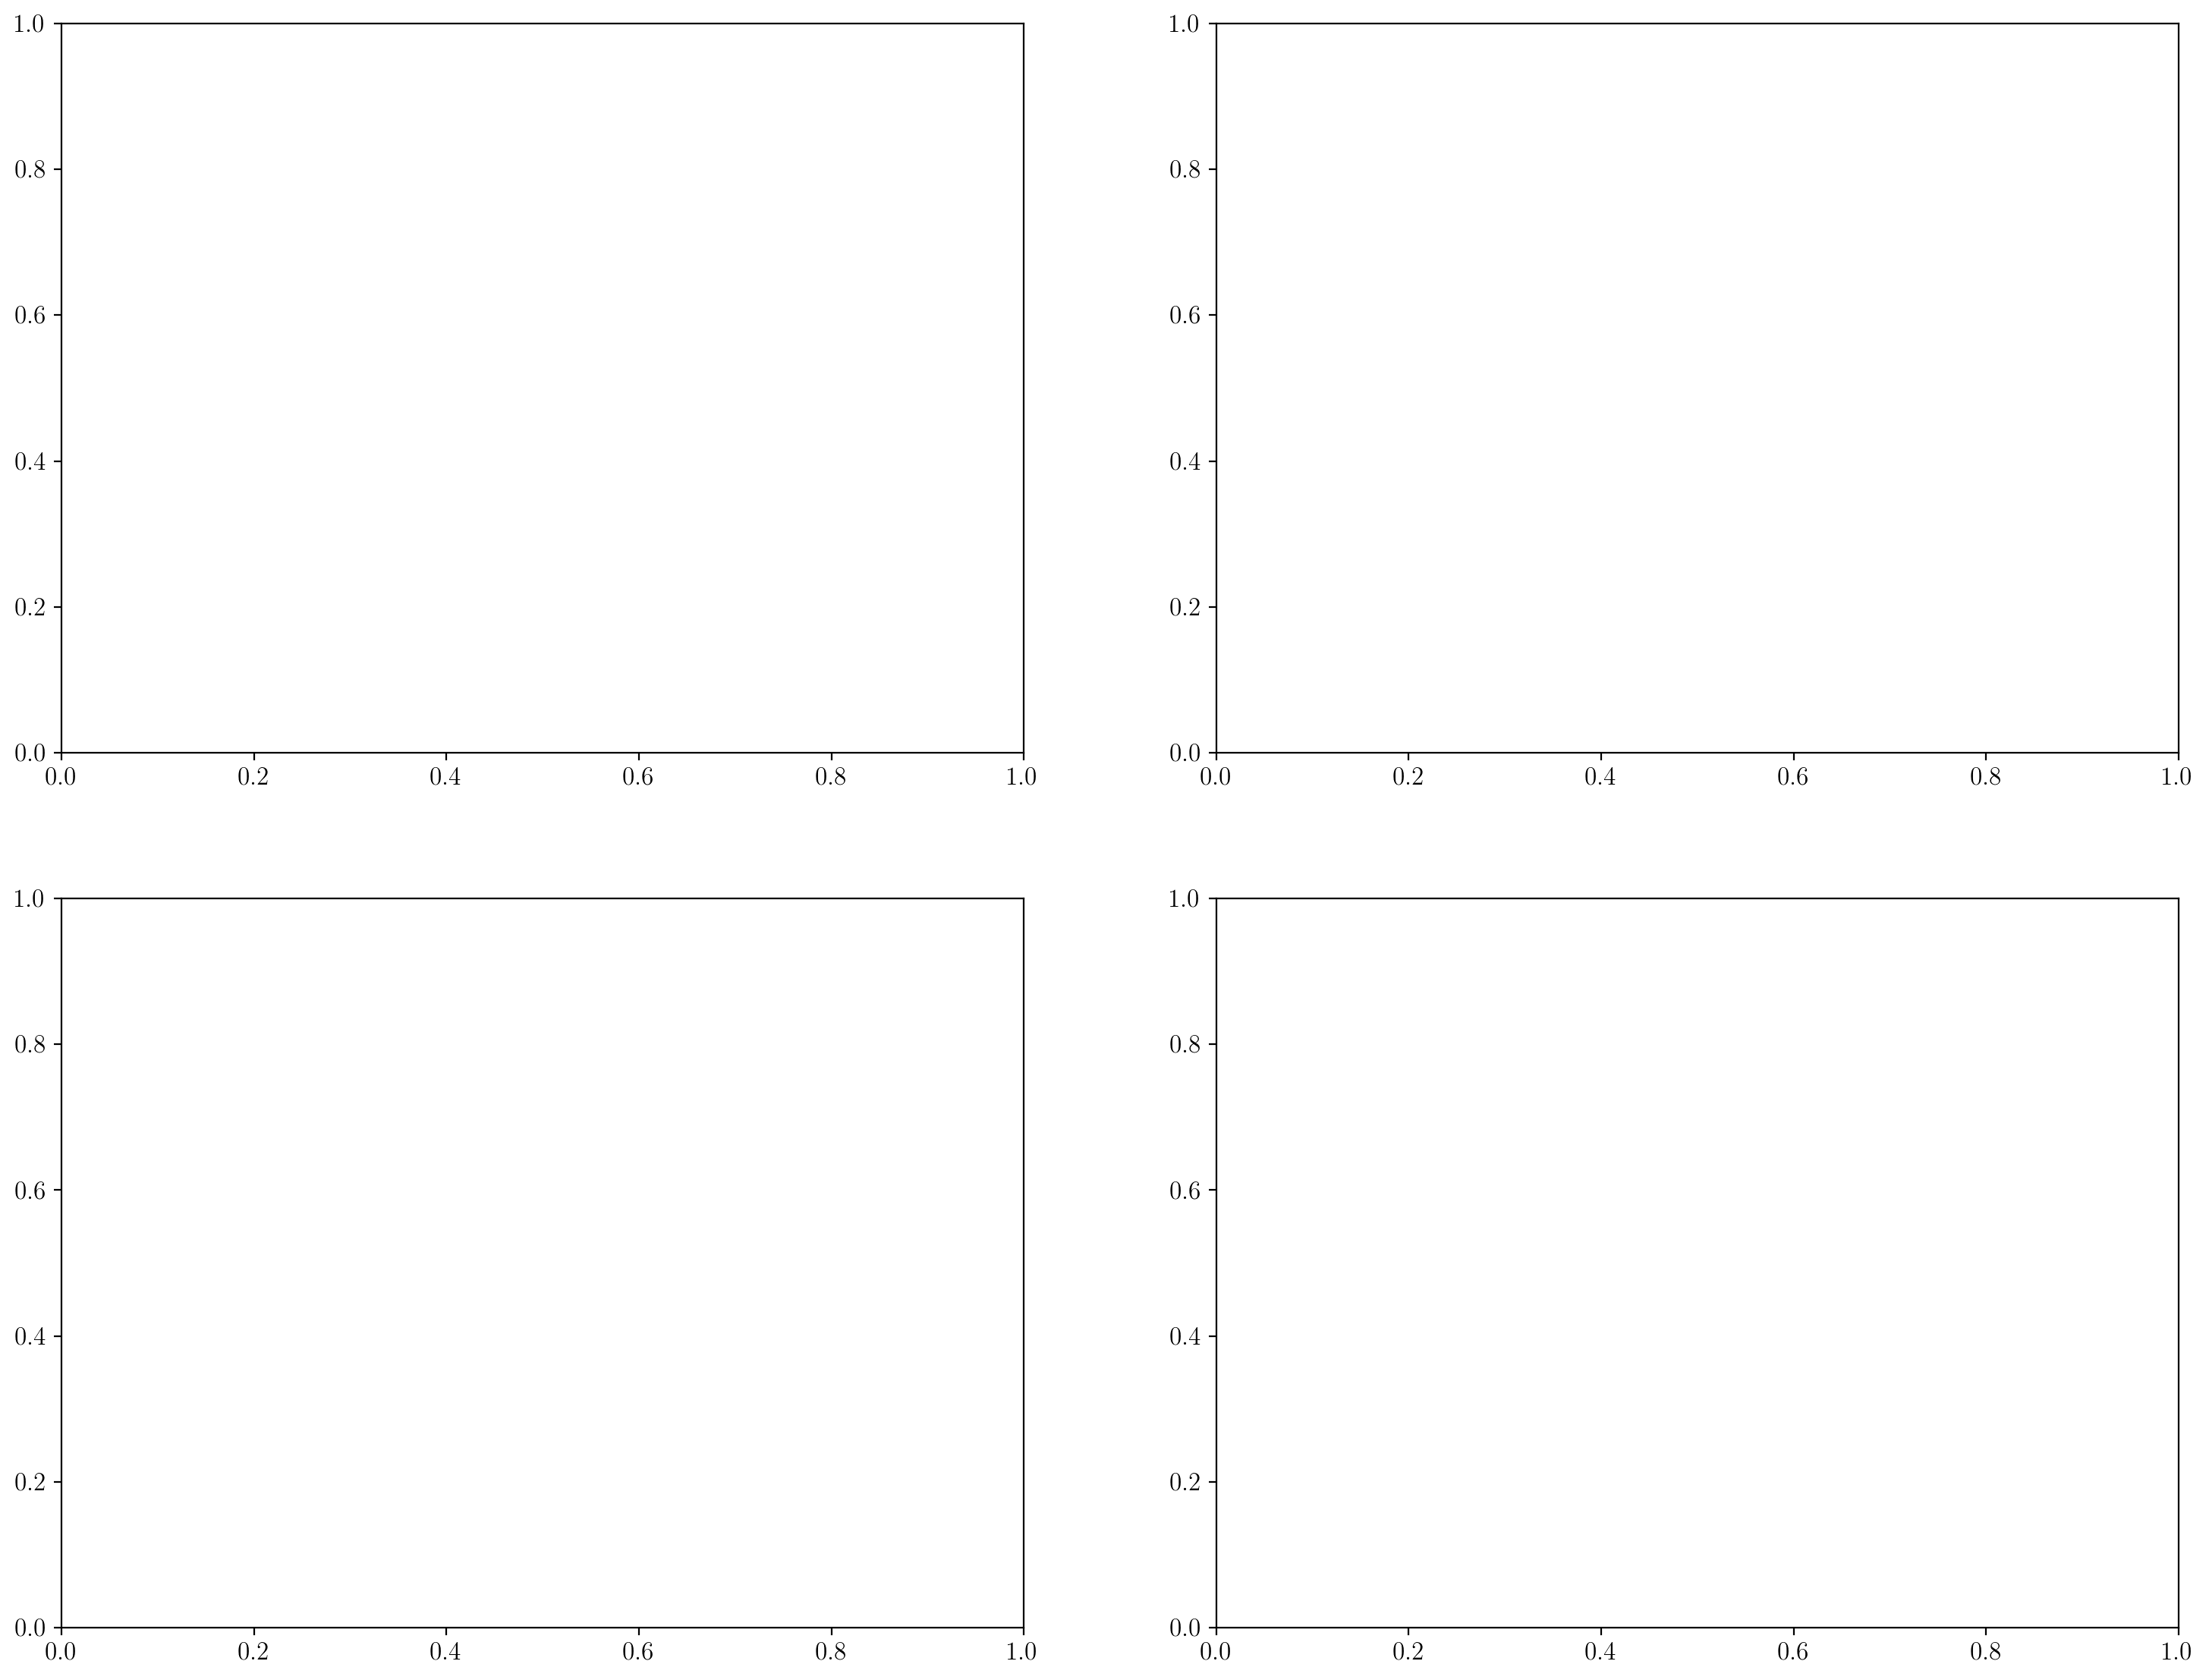

In [311]:
eta = nlb_eta

plt.rcParams["figure.figsize"] = (18, 14)
fig, ax= plt.subplots(2, 2)
#ah1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_analytic_Xe, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM (analytic)')
bh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_SHM_Xe, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM')
#bh1t=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_SHM, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM CDMS')
#ch1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_SHMpp_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='SHM++')
#dh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_halo_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='SHM++ Halo')
#eh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_ssg_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='SHM++ Sausage')
xh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='solid', label='NLB')
#yh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_halo_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='dashed', label='NLB Halo')
#zh1=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_subst_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='dotted', label='NLB Substructure')
xh1a=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='solid', label='NLB')
#yh1a=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_halo_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='dashed', label='NLB Halo Full')
#zh1a=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_subst_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='dotted', label='NLB Substructure Full')
#xh1b=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='NLB Full')
#yh1b=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_halo_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='NLB Halo Full Jun')
#zh1b=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_subst_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='NLB Substructure Full Jun')
#xh1c=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='solid', label='NLB Full Dec')
#yh1c=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_halo_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='dashed', label='NLB Halo Full Dec')
#zh1c=ax[0, 0].contour(interp_mDM_grid, interp_log_sigma_h1_grid, interp_C0_h1_grid_NLB_subst_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='dotted', label='NLB Substructure Full Dec')
#ah1.collections[0].set_label('SHM (analytic)');
bh1.collections[0].set_label('SHM');
#bh1t.collections[0].set_label('SHM (CDMS)');
#ch1.collections[0].set_label('SHM++')
#dh1.collections[0].set_label('SHM++ Halo');
#eh1.collections[0].set_label('SHM++ Sausage');
xh1.collections[0].set_label('NLB Fire')
#yh1.collections[0].set_label('NLB Halo');
#zh1.collections[0].set_label('NLB Substructure');
xh1a.collections[0].set_label('NLB')
#yh1a.collections[0].set_label('NLB Halo Full');
#zh1a.collections[0].set_label('NLB Substructure Full');
#xh1b.collections[0].set_label('NLB Jun')
#yh1b.collections[0].set_label('NLB Halo Jun');
#zh1b.collections[0].set_label('NLB Substructure Jun');
#xh1c.collections[0].set_label('NLB Dec')
#yh1c.collections[0].set_label('NLB Halo Dec');
#zh1c.collections[0].set_label('NLB Substructure Dec');
ax[0, 0].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[0, 0].set_xlim(min_mass, max_mass);
ax[0, 0].set_xscale('log')
ax[0, 0].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[0, 0].set_ylabel(r"${\rm Log_{10}}(h_1) \ {\rm [GeV^{-2}]}$", fontsize=18)
ax[0, 0].set_ylim(h1_low_sigma, h1_high_sigma)
ax[0, 0].minorticks_on();
ax[0, 0].tick_params(axis='both', which='major', labelsize=18)
ax[0, 0].tick_params(axis='both', which='minor', labelsize=16)
plt.setp(ax[0, 0].get_yticklabels()[0], visible=False)

#al1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_analytic_Xe, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM (analytic)')
bl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_SHM_Xe, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM')
#cl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_SHMpp_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='SHM++')
#dl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_halo_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='SHM++ Halo')
#el1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_ssg_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='SHM++ Sausage')
xl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='solid', label='NLB')
#yl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_halo_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='dashed', label='NLB Halo')
#zl1=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_subst_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='dotted', label='NLB Substructure')
xl1a=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='solid', label='NLB')
#yl1a=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_halo_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='dashed', label='NLB Halo Full')
#zl1a=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_subst_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='dotted', label='NLB Substructure Full')
#xl1b=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='NLB Full')
#yl1b=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_halo_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='NLB Halo Full Jun')
#zl1b=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_subst_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='NLB Substructure Full Jun')
#xl1c=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='solid', label='NLB Full Dec')
#yl1c=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_halo_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='dashed', label='NLB Halo Full Dec')
#zl1c=ax[0, 1].contour(interp_mDM_grid, interp_log_sigma_l1_grid, interp_C0_l1_grid_NLB_subst_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='dotted', label='NLB Substructure Full Dec')
#al1.collections[0].set_label('SHM (analytic)');
bl1.collections[0].set_label('SHM');
#cl1.collections[0].set_label('SHM++')
#dl1.collections[0].set_label('SHM++ Halo');
#el1.collections[0].set_label('SHM++ Sausage');
xl1.collections[0].set_label('NLB Fire')
#yl1.collections[0].set_label('NLB Halo');
#zl1.collections[0].set_label('NLB Substructure');
xl1a.collections[0].set_label('NLB')
#yl1a.collections[0].set_label('NLB Halo Full');
#zl1a.collections[0].set_label('NLB Substructure Full');
#xl1b.collections[0].set_label('NLB Jun')
#yl1b.collections[0].set_label('NLB Halo Jun');
#zl1b.collections[0].set_label('NLB Substructure Jun');
#xl1c.collections[0].set_label('NLB Dec')
#yl1c.collections[0].set_label('NLB Halo Dec');
#zl1c.collections[0].set_label('NLB Substructure Dec');
ax[0, 1].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[0, 1].set_xlim(min_mass, max_mass);
ax[0, 1].set_xscale('log')
ax[0, 1].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[0, 1].set_ylabel(r"${\rm Log_{10}}(l_1)$", fontsize=18)
ax[0, 1].set_ylim(l1_low_sigma, l1_high_sigma);
ax[0, 1].minorticks_on();
ax[0, 1].tick_params(axis='both', which='major', labelsize=18)
ax[0, 1].tick_params(axis='both', which='minor', labelsize=16)
plt.setp(ax[0, 1].get_yticklabels()[0], visible=False) 

#ah2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_analytic_Xe, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM (analytic)')
bh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_SHM_Xe, levels=[0.9], alpha=0.6, colors='black', linestyles='solid', label='SHM')
#ch2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_SHMpp_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='SHM++')
#dh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_halo_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='SHM++ Halo')
#eh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_ssg_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='SHM++ Sausage')
xh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='solid', label='NLB')
#yh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_halo_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='dashed', label='NLB Halo')
#zh2=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_subst_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='dotted', label='NLB Substructure')
xh2a=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='solid', label='NLB')
#yh2a=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_halo_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='dashed', label='NLB Halo Full')
#zh2a=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_subst_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='dotted', label='NLB Substructure Full')
#xh2b=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='NLB Full')
#yh2b=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_halo_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='NLB Halo Full Jun')
#zh2b=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_subst_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='NLB Substructure Full Jun')
#xh2c=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='solid', label='NLB Full Dec')
#yh2c=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_halo_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='dashed', label='NLB Halo Full Dec')
#zh2c=ax[1, 0].contour(interp_mDM_grid, interp_log_sigma_h2_grid, interp_C0_h2_grid_NLB_subst_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='dotted', label='NLB Substructure Full Dec')
#ah2.collections[0].set_label('SHM (analytic)');
bh2.collections[0].set_label('SHM');
#ch2.collections[0].set_label('SHM++')
#dh2.collections[0].set_label('SHM++ Halo');
#eh2.collections[0].set_label('SHM++ Sausage');
xh2.collections[0].set_label('NLB Fire')
#yh2.collections[0].set_label('NLB Halo');
#zh2.collections[0].set_label('NLB Substructure');
xh2a.collections[0].set_label('NLB')
#yh2a.collections[0].set_label('NLB Halo Full');
#zh2a.collections[0].set_label('NLB Substructure Full');
#xh2b.collections[0].set_label('NLB Jun')
#yh2b.collections[0].set_label('NLB Halo Jun');
#zh2b.collections[0].set_label('NLB Substructure Jun');
#xh2c.collections[0].set_label('NLB Dec')
#yh2c.collections[0].set_label('NLB Halo Dec');
#zh2c.collections[0].set_label('NLB Substructure Dec');
ax[1, 0].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[1, 0].set_xlim(min_mass, max_mass);
ax[1, 0].set_xscale('log')
ax[1, 0].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[1, 0].set_ylabel(r"${\rm Log_{10}}(h_2) \ {\rm [GeV^{-3}]}$", fontsize=18)
ax[1, 0].set_ylim(h2_low_sigma, h2_high_sigma)
ax[1, 0].minorticks_on();
ax[1, 0].tick_params(axis='both', which='major', labelsize=18)
ax[1, 0].tick_params(axis='both', which='minor', labelsize=16)
plt.setp(ax[1, 0].get_yticklabels()[0], visible=False)

#al2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_analytic_Xe, levels=[0.9], alpha=0.6, colors='black', linestyles='solid')
bl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_SHM_Xe, levels=[0.9], alpha=0.6, colors='black', linestyles='solid')
#cl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_SHMpp_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid')
#dl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_halo_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed')
#el2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_ssg_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted')
xl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='solid', label='NLB')
#yl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_halo_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='dashed', label='NLB Halo')
#zl2=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_subst_Xe, levels=[0.9], alpha=0.6, colors='red', linestyles='dotted', label='NLB Substructure')
xl2a=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='solid', label='NLB')
#yl2a=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_halo_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='dashed', label='NLB Halo Full')
#zl2a=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_subst_full_Xe, levels=[0.9], alpha=0.6, colors='green', linestyles='dotted', label='NLB Substructure Full')
#xl2b=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='solid', label='NLB Full')
#yl2b=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_halo_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dashed', label='NLB Halo Full Jun')
#zl2b=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_subst_full_Jun_Xe, levels=[0.9], alpha=0.6, colors='blue', linestyles='dotted', label='NLB Substructure Full Jun')
#xl2c=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='solid', label='NLB Full Dec')
#yl2c=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_halo_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='dashed', label='NLB Halo Full Dec')
#zl2c=ax[1, 1].contour(interp_mDM_grid, interp_log_sigma_l2_grid, interp_C0_l2_grid_NLB_subst_full_Dec_Xe, levels=[0.9], alpha=0.6, colors='violet', linestyles='dotted', label='NLB Substructure Full Dec')
#al2.collections[0].set_label('SHM (analytic)');
bl2.collections[0].set_label('SHM');
#cl2.collections[0].set_label('SHM++')
#dl2.collections[0].set_label('SHM++ Halo');
#el2.collections[0].set_label('SHM++ Sausage');
xl2.collections[0].set_label('NLB Fire')
#yl2.collections[0].set_label('NLB Halo');
#zl2.collections[0].set_label('NLB Substructure');
xl2a.collections[0].set_label('NLB')
#yl2a.collections[0].set_label('NLB Halo Full');
#zl2a.collections[0].set_label('NLB Substructure Full');
#xl2b.collections[0].set_label('NLB Jun')
#yl2b.collections[0].set_label('NLB Halo Jun');
#zl2b.collections[0].set_label('NLB Substructure Jun');
#xl2c.collections[0].set_label('NLB Dec')
#yl2c.collections[0].set_label('NLB Halo Dec');
#zl2c.collections[0].set_label('NLB Substructure Dec');
ax[1, 1].legend(title=('$\eta_{\mathrm{sub}} = $ '+str(eta)), loc='best');
ax[1, 1].set_xlim(min_mass, max_mass);
ax[1, 1].set_xscale('log')
ax[1, 1].set_xlabel(r"$m_\chi \ {\rm [GeV]}$", fontsize=18)
ax[1, 1].set_ylabel(r"${\rm Log_{10}}(l_2) \ {\rm [GeV^{-1}]}$", fontsize=18)
ax[1, 1].set_ylim(l2_low_sigma, l2_high_sigma)
ax[1, 1].minorticks_on();
ax[1, 1].tick_params(axis='both', which='major', labelsize=18)
ax[1, 1].tick_params(axis='both', which='minor', labelsize=16)
plt.setp(ax[1, 1].get_yticklabels()[0], visible=False)
plt.suptitle(r'${\rm SI \ scattering \ Xe}$', fontsize=20);
plt.savefig('exclusion_curve_NLB_si.pdf', bbox_inches='tight');

## Sanity checks

### Xe form factor

In [ ]:
ER_array= np.linspace(1, 100, 1000)
f11_array= [np.sum([F_1_1(q_func(x*1e-6, 131.3*AMUtoGeV), 'p', 'p', '131Xe'), 2*F_1_1(q_func(x*1e-6, 131.3*AMUtoGeV), 'p', 'n', '131Xe'), \
                                                                    F_1_1(q_func(x*1e-6, 131.3*AMUtoGeV), 'n', 'n', '131Xe')]) for x in ER_array]
helm_array= [131.3**2*helm_form_factor(q_func(x*1e-6, 131.3*AMUtoGeV), 131.3) for x in ER_array]

In [ ]:
plt.plot(ER_array, f11_array);
plt.plot(ER_array, helm_array);

### Ge form factor

In [68]:
ge_ff_array= [72.64**2*pow(Ge_form_factor(q_func(x*keVtoGeV, 72.64*AMUtoGeV)), 2) for x in ER_array]

f11_Ge_array= [np.sum([F_1_1(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'p', '72Ge'), 2*F_1_1(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'p', 'n', '72Ge'), \
                                                                F_1_1(q_func(x*keVtoGeV, 72.64*AMUtoGeV), 'n', 'n', '72Ge')]) for x in ER_array]

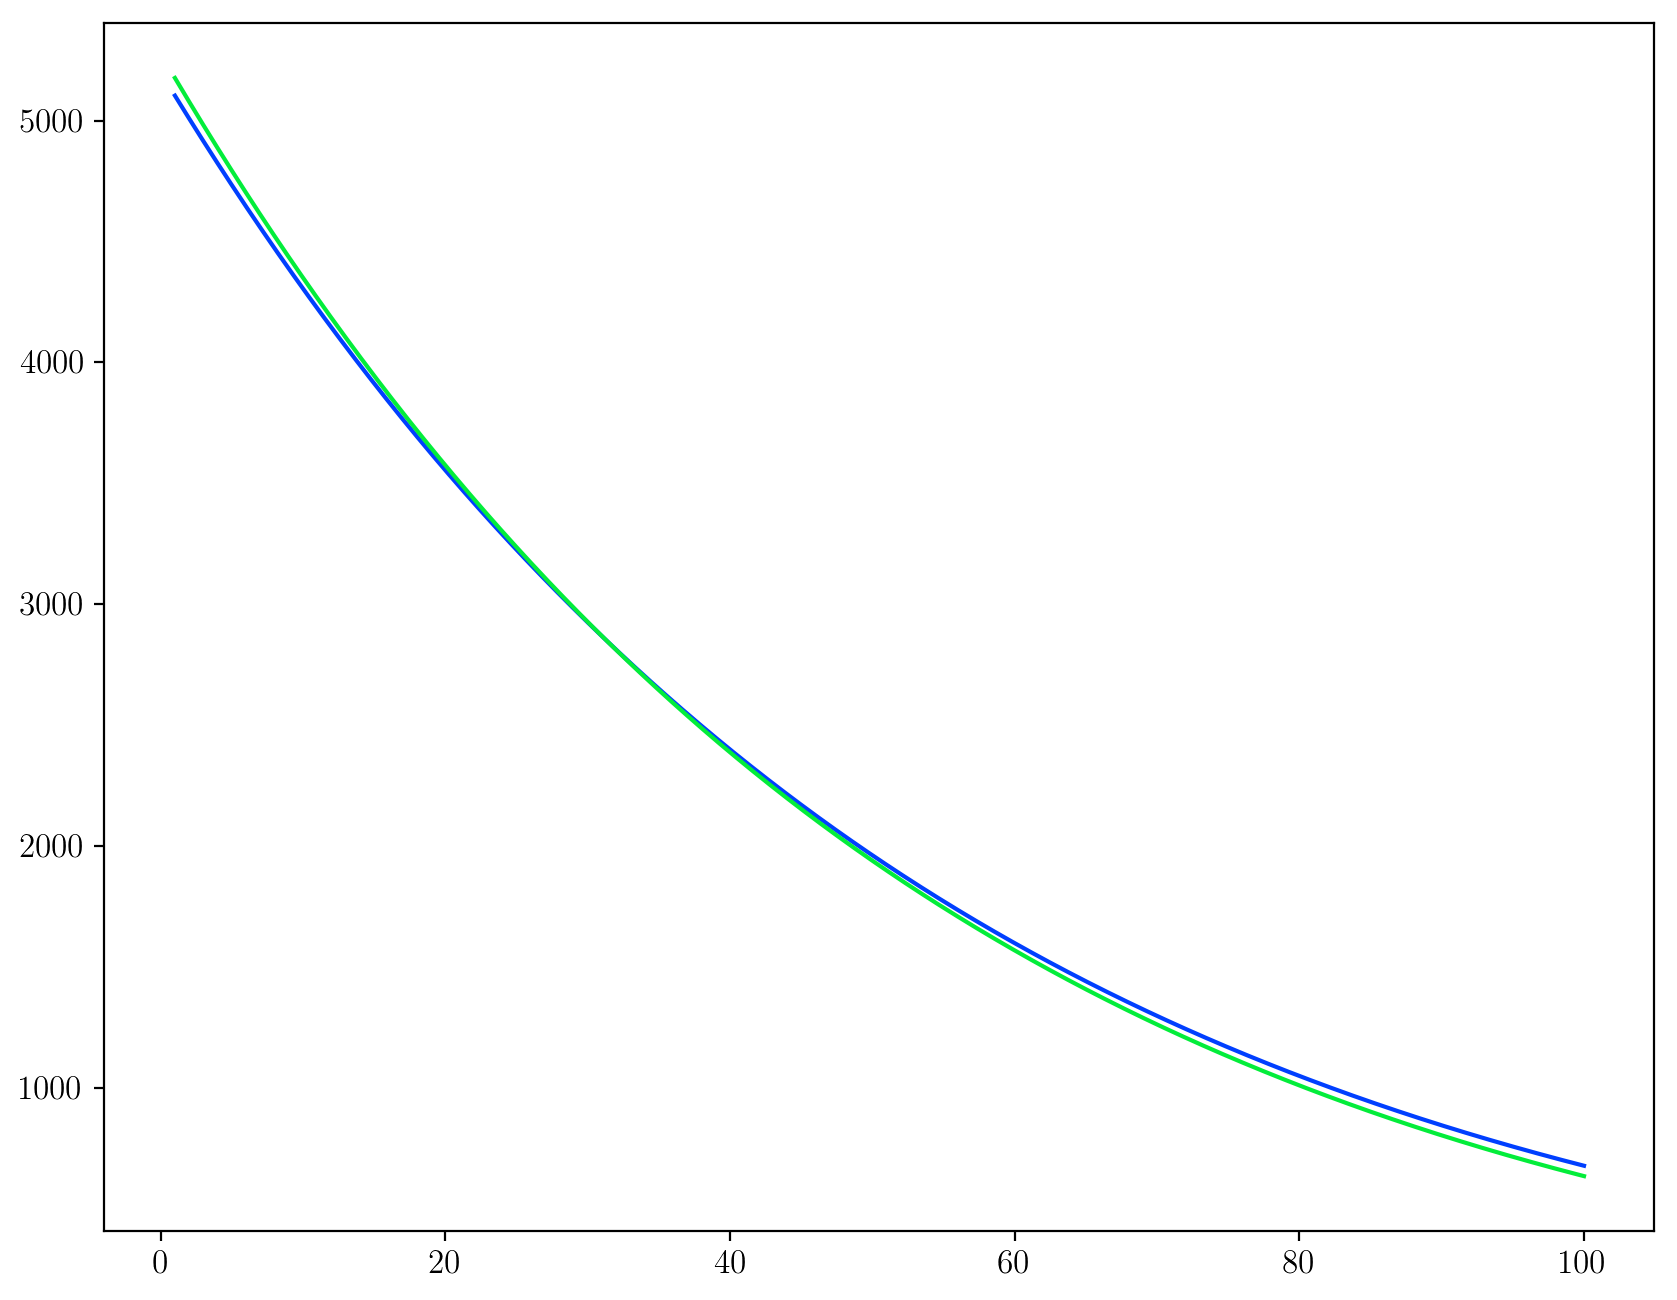

In [69]:
plt.plot(ER_array, f11_Ge_array);
plt.plot(ER_array, ge_ff_array);

In [290]:
def Ge_form_factor(q): # temp function
    #q is in GeV
    if q==0:
        return 1.0
    else:
        R = 10.0*fmtoInverseGeV
        Ge72FBCoeff= [0.38083E-1, 0.59342E-1, 0.47718E-2, -0.29953E-1, -0.88476E-2, 0.96205E-2, 0.47901E-2, \
                       -0.16869E-2, -0.15406E-2, -0.97230E-4, -0.47640E-4, -0.15669E-5, 0.67076E-5, -0.44500E-5, \
                        0.22158E-5];
        num_factor= np.sum(pow(-1, i)*Ge72FBCoeff[i-1]/(pow(i*np.pi, 2) - pow(q*R, 2)) for i in xrange(1, len(Ge72FBCoeff)+1))
        den_factor= np.sum(pow(-1, i)*Ge72FBCoeff[i-1]/pow(i*np.pi, 2) for i in range(1, len(Ge72FBCoeff)+1))
        return (np.sin(q*R)/(q*R))*num_factor/den_factor
